# Mr. Robot Secret Scene Detector
The purpose of this exercise is to see if we can programmatically find scenes in Mr. Robot that might contain some hidden message. The initial methodology will simply involve finding extremely short cut scenes.

I'll use PySceneDetect to segment an episode by scene cuts. It will output a CSV with timestamps designating where scene cuts occur as well as export images that correspond to the scene.

In [1]:
# For manipulating CSVs
import numpy as np
import pandas as pd

In [31]:
# For moving files
import os

In [178]:
# For showing images in this notebook
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import base64

In [179]:
# Don't truncate Dataframes
pd.set_option('display.max_colwidth', -1)

# First Attempt
## Import the scene data
Using PySceneDetect, I detected all the scenes in the episode and exported the data to a CSV.

Settings Used:

- scenedetect -i mr-robot-half-size.m4v -d content -t 30 --csv-output scene_data.csv (First time without exporting image or tweaking the frame threshold)


In [171]:
movie_data = pd.read_csv("previous_experiments/scene_data.csv", skiprows=[0])

Sample of some of the data

In [172]:
movie_data.head()

Scene Number  Frame Number (Start)      Timecode  Start Time (seconds)  \
0  1             998                   00:00:41.624  41.624584              
1  2             1072                  00:00:44.710  44.710976              
2  3             1116                  00:00:46.546  46.546128              
3  4             1241                  00:00:51.759  51.759628              
4  5             1423                  00:00:59.350  59.350484              

   Length (seconds)  
0  3.086392          
1  1.835152          
2  5.213500          
3  7.590856          
4  3.461764

From examining a snippet of the data, we see there is a column that contains the length of time of a scene. We can filter the data to find parts of the show where the scene length is less than a certain amount of time that might be plausible for a hidden message to appear.

I'll rename the columns so that I can start to filter the results by a range of values.

In [173]:
movie_data.columns = ['scene_number', 'frame_number_start', 'time_code', 'start_time', 'length']
movie_data.head()

scene_number  frame_number_start     time_code  start_time    length
0  1             998                 00:00:41.624  41.624584   3.086392
1  2             1072                00:00:44.710  44.710976   1.835152
2  3             1116                00:00:46.546  46.546128   5.213500
3  4             1241                00:00:51.759  51.759628   7.590856
4  5             1423                00:00:59.350  59.350484   3.461764

## Trimming the results by the duration

In [27]:
short_scenes = movie_data[(movie_data.length < 1)]
"Number of scenes below 1 second: {}".format(len(short_scenes))

'Number of scenes below 1 second: 53'

We see that for this episode of the show, there are **53** scenes that PySceneDetect has found below one second. However, that might be too much time for a split second image to show on screen. We can see if there are scenes that are as short as half a second.

In [25]:
super_short_scenes = movie_data[(movie_data.length < 0.5)]
"Number of scenes below 0.5 seconds: {}".format(len(super_short_scenes))

'Number of scenes below 0.5 seconds: 0'

When I filter PySceneDetect results to only those scenes which are less than half a second, it didn't find anything. This however doesn't mean such scenes don't exist, it might mean that in calibrating the detector, we may need to increase the sensitivity of the detector.

There are a number of ways to do it, such as decreasing the threshold at which it notices a scene change. However, since we are most interested in detecting a scene that might be as short as a single frame or so, it's likely more fruitful to see how PySceneDetect treats frames.

From the console documentation of PySceneDetect:

> **-m num_frames, --min-scene-length num_frames: Minimum length, in frames, before another scene cut can be generated. (default: 15)**

We can see that the default settings of PySceneDetect at minimum allow for 15 frames to pass before allowing a scene cut.

## Examining which scenes are found

In [30]:
# Sampling of the scenes founds
short_scenes[:5]

scene_number  frame_number_start     time_code  start_time    length
59             60               10761  00:07:28.819  448.819788  0.709036
126           127               18033  00:12:32.120  752.120364  0.709036
127           128               18050  00:12:32.829  752.829400  0.625620
132           133               18242  00:12:40.837  760.837336  0.667328
133           134               18258  00:12:41.504  761.504664  0.750744

# Second Attempt
## Allowing for shorter scenes

Because the initial attempt had very few scenes that were detected below half a second, I decided to loosen the restrictions on the detector by allowing it to cut scenes as short as 4 frames per second.

> scenedetect -i mr-robot-half-size.m4v -d content -t 30 --csv-output OUTPUT.csv -si -m 4

In [204]:
experiment_2 = "experiment-2"
exp_2 = pd.read_csv("experiment-2.csv", skiprows=[0])
exp_2.columns = ['scene_number', 'frame_number_start', 'time_code', 'start_time', 'length']
exp_2.head()

scene_number  frame_number_start     time_code  start_time    length
0  1             998                 00:00:41.624  41.624584   3.086392
1  2             1072                00:00:44.710  44.710976   1.835152
2  3             1116                00:00:46.546  46.546128   5.213500
3  4             1241                00:00:51.759  51.759628   7.590856
4  5             1423                00:00:59.350  59.350484   3.461764

## Organize images into two folders based on scene duration
Finding all scenes in the movie ends up creating screenshots of all scenes. We want to just look at the screenshots of the shortest lengths.

Steps in the process:

1) Create containing folders (images/short-scenes, images/remaining-scenes)

2) Look at the scene numbers that we care about from the PySceneDetect CSV, and move those scenes into its own folder.

3) Move every other image into another folder.

In [188]:
f_prefix = "mr-robot-half-size.m4v.Scene-"
f_suffix_in = "-OUT.jpg"
f_suffix_out = "-IN.jpg"

def format_file_names(scene_numbers):
    """ Takes scene numbers and converts them into file names that correspond
    to the files in the current directory
    
    Returns: A list of tuples of image file names
    """
    filenames = [(f_prefix + str(scene_number) + f_suffix_in,
                  f_prefix + str(scene_number) + f_suffix_out) for scene_number in scene_numbers]
    return filenames

def move_in_and_out_images(files, target):
    """ Takes a list of tuples containing file names and moves them to the target directory   
    """
    for filenames in files:
        for filename in filenames:
            destination = os.path.join(target, filename)
            os.rename(filename, destination)
            
def create_experiment_image_directory(experiment, directory_suffix):
    """ Takes an experiment name, creates a directory 
    
    Returns: Location of the directory
    """
    directory = os.path.join(experiment, directory_suffix)
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

In [205]:
exp2_short_scenes_dir = create_experiment_image_directory(experiment_2, "images/short-scenes")
exp2_remaining_scenes_dir = create_experiment_image_directory(experiment_2, "images/remaining-scenes")

In [191]:
# Separate which scenes to consider short and not short
exp_2_short_scenes = exp_2[(exp_2.length < 0.5)]
exp_2_remaining_scenes = exp_2[(exp_2.length > 0.5)]
"Number of scenes below 0.5 seconds: {}".format(len(exp_2_short_scenes))

'Number of scenes below 0.5 seconds: 92'

In [192]:
# Have to make sure scene IDs have leading zeros for two digit numbers similar to the file outputs
exp_2_short_scene_ids = exp_2_short_scenes['scene_number'].apply('{:0>3}'.format)
exp_2_remaining_scene_ids = exp_2_remaining_scenes['scene_number'].apply('{:0>3}'.format)

In [193]:
# Create a list of tuples of the in and out files for each scene
exp_2_short_scene_files = format_file_names(exp_2_short_scene_ids)
exp_2_remaining_scene_files = format_file_names(exp_2_remaining_scene_ids)

In [194]:
# Then move the images into their own experiment directory, seperated by whether they are short or not short
move_in_and_out_images(exp_2_short_scene_files, exp2_short_scenes_dir)
move_in_and_out_images(exp_2_remaining_scene_files, exp2_remaining_scenes_dir)

## Organize the scene images into a table

We want to be able to look at the short scenes detected to see if we find anything out of the ordinary.

First, we'll take the relevant file names and add them to a Pandas DataFrame with the line of information related to each scene. Then we'll use Pillow and iPython display to display HTML tables so that images can be included.

In [198]:
exp_2_image_path = [(os.path.join(exp2_short_scenes_dir, in_path), 
                            os.path.join(exp2_short_scenes_dir, out_path))
                            for out_path, in_path in exp_2_short_scene_files]
exp_2_image_path = pd.DataFrame(exp_2_image_path)
exp_2_image_path.columns = ['scene_start', 'scene_end']
exp_2_short_scenes_complete = pd.concat([exp_2_short_scenes.reset_index(), exp_2_image_path], axis=1)

In [199]:
exp_2_short_scenes_complete[:5]

index  scene_number  frame_number_start     time_code  start_time  \
0  50     51            9270                00:06:26.633  386.633160   
1  60     61            10761               00:07:28.819  448.819788   
2  61     62            10765               00:07:28.986  448.986620   
3  62     63            10769               00:07:29.153  449.153452   
4  63     64            10778               00:07:29.528  449.528824   

     length  \
0  0.417080   
1  0.166832   
2  0.166832   
3  0.375372   
4  0.166832   

                                                                scene_start  \
0  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-051-IN.jpg   
1  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-061-IN.jpg   
2  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-062-IN.jpg   
3  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-063-IN.jpg   
4  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-064-IN.jpg   

                                                                   scene_end  
0  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-051-OUT.jpg  
1  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-061-OUT.jpg  
2  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-062-OUT.jpg  
3  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-063-OUT.jpg  
4  experiment-2/images/short-scenes/mr-robot-half-size.m4v.Scene-064-OUT.jpg

In [175]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((350, 350), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [201]:
exp_2_short_scenes_complete['scene_start_image'] = exp_2_short_scenes_complete.scene_start.map(lambda f: get_thumbnail(f))
exp_2_short_scenes_complete['scene_end_image'] = exp_2_short_scenes_complete.scene_end.map(lambda f: get_thumbnail(f))


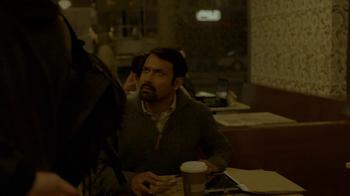
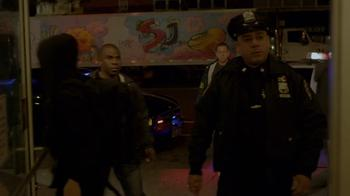
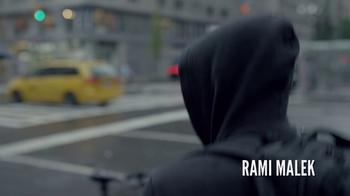
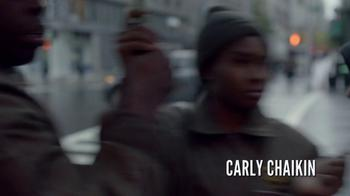
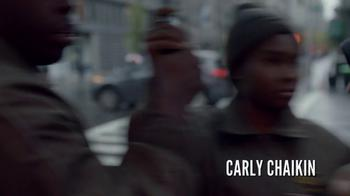
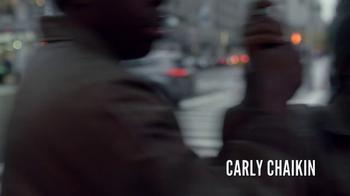
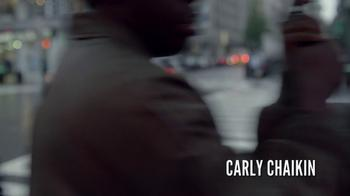
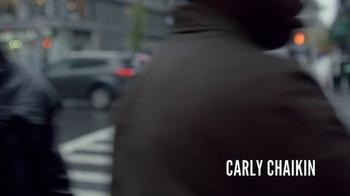
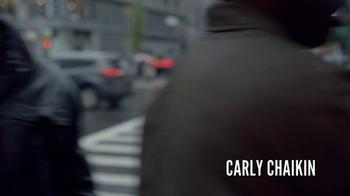
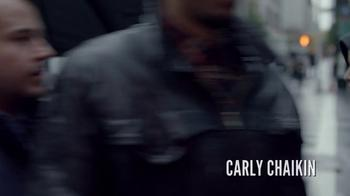
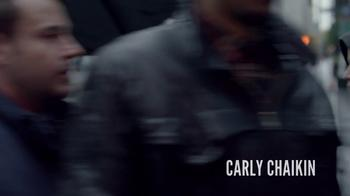
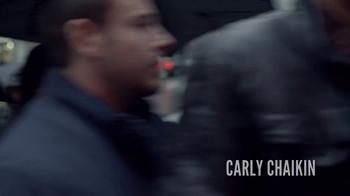
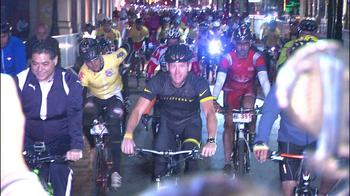
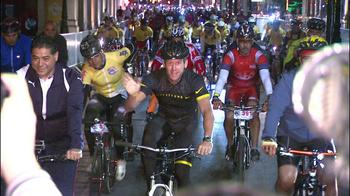
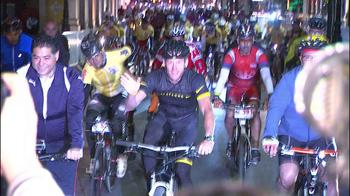
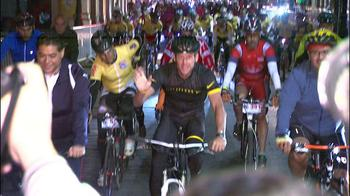
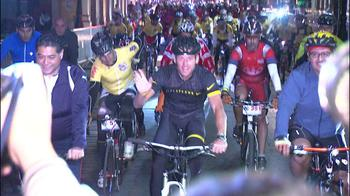
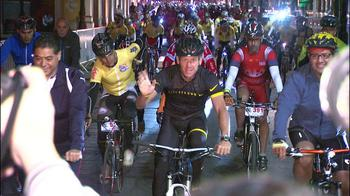
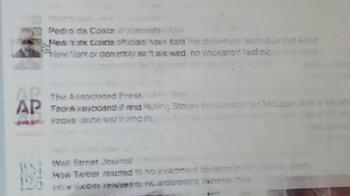
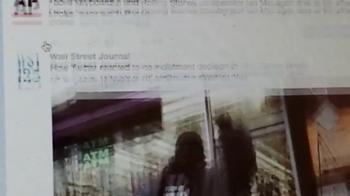
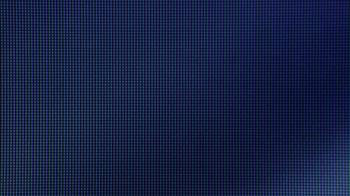
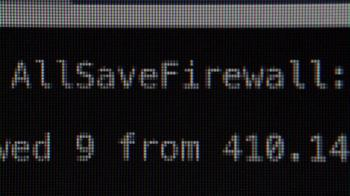
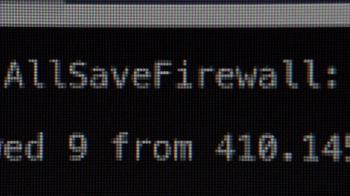
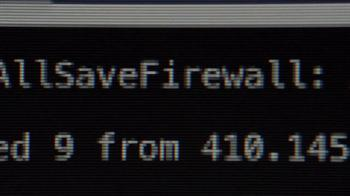
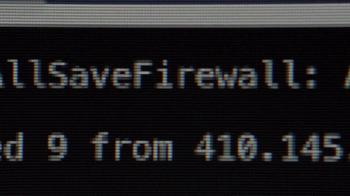
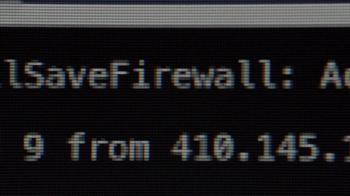
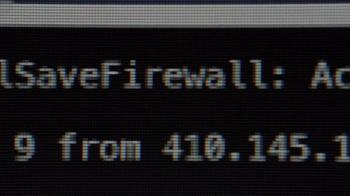
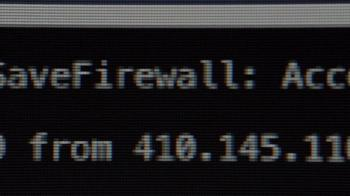
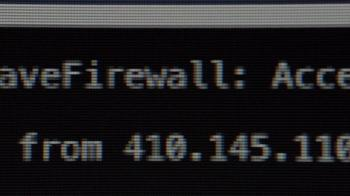
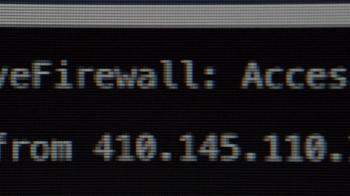
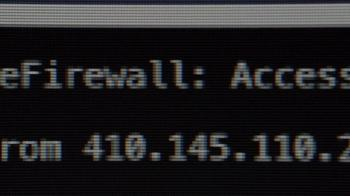
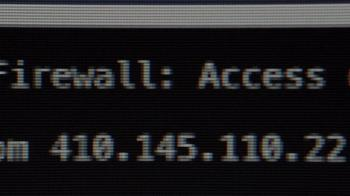
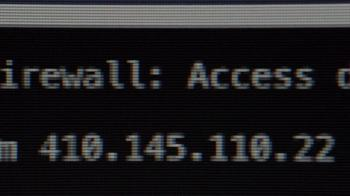
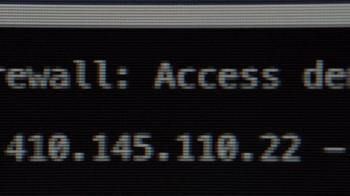
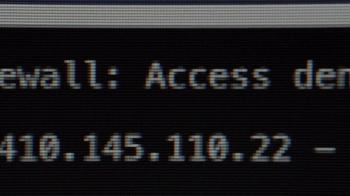
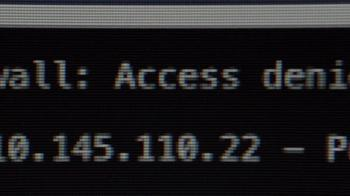
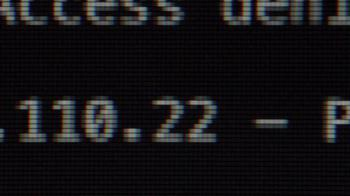
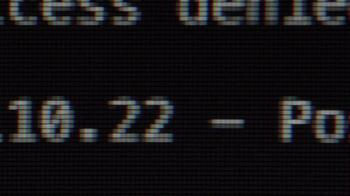
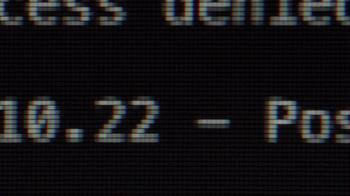
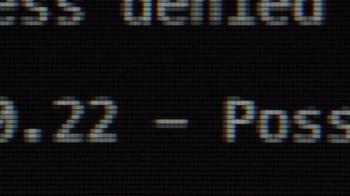
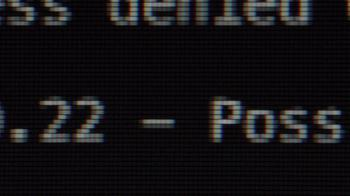
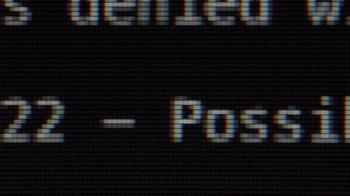
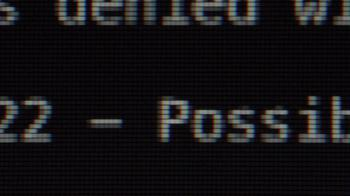
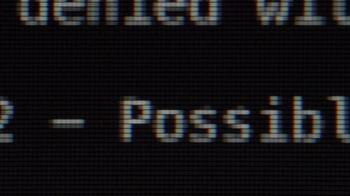
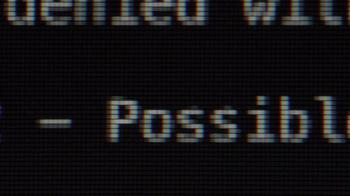
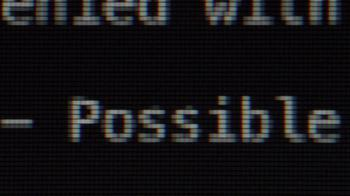
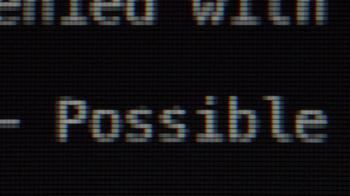
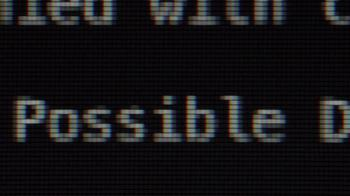
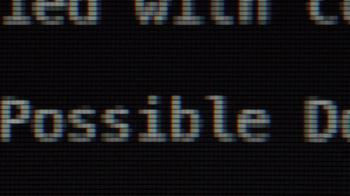
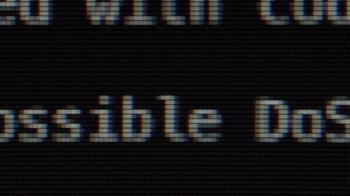
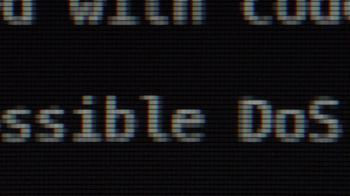
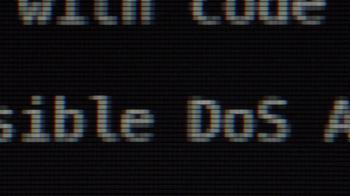
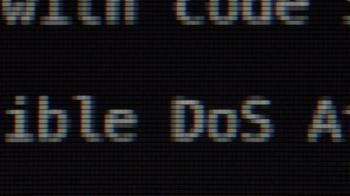
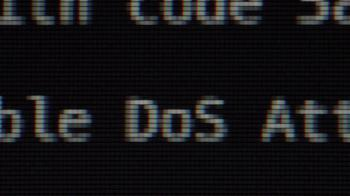
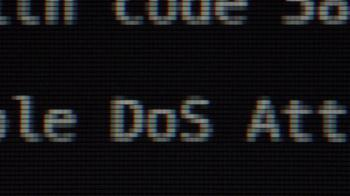
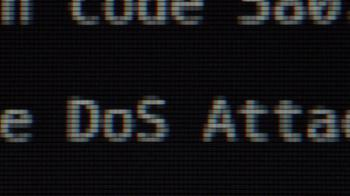
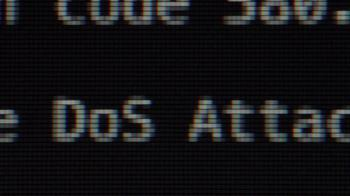
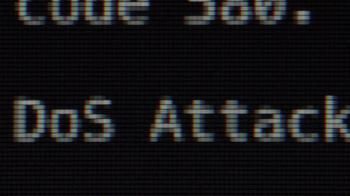
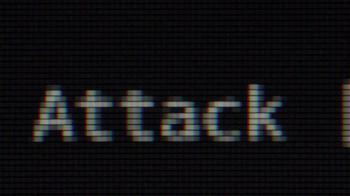
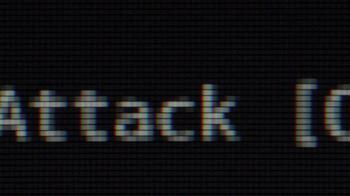
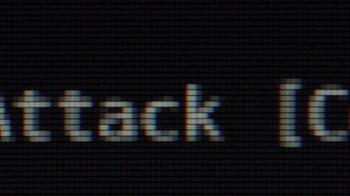
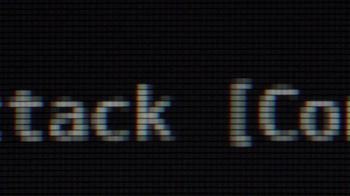
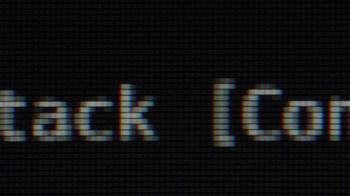
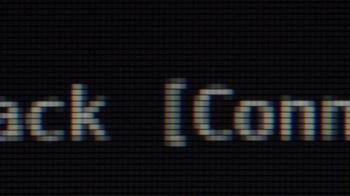
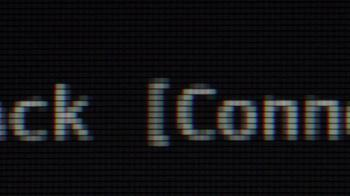
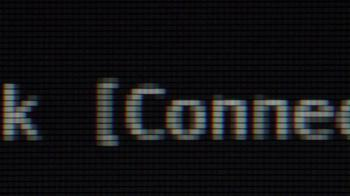
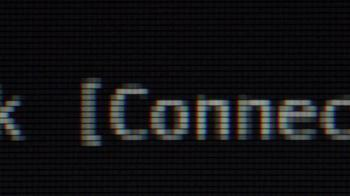
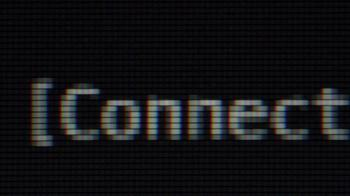
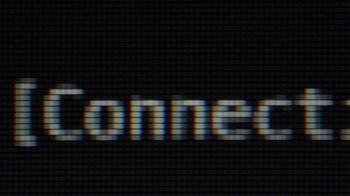
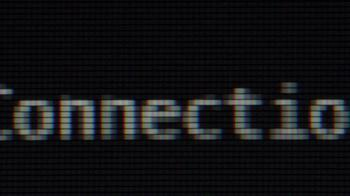
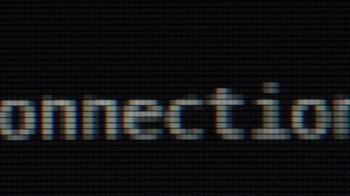
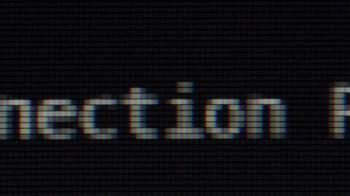
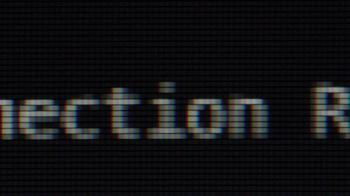
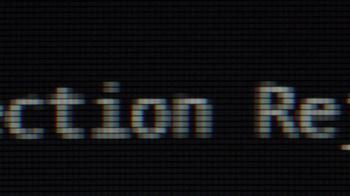
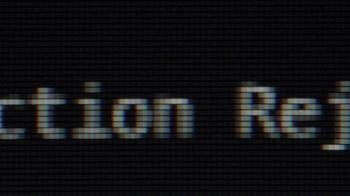
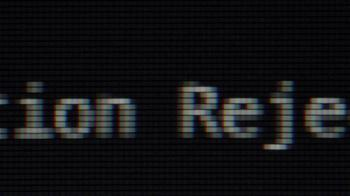
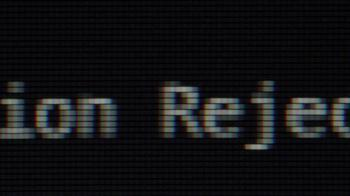
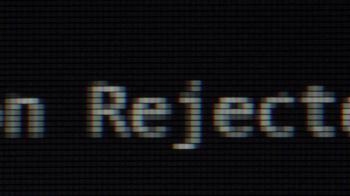
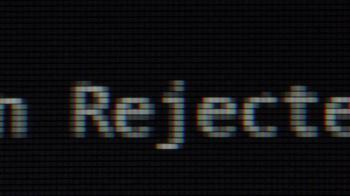
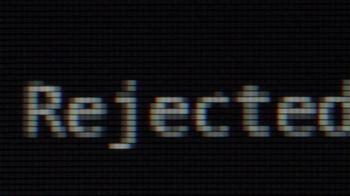
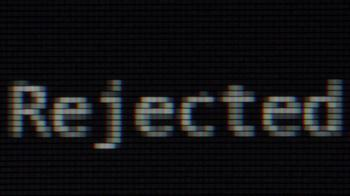
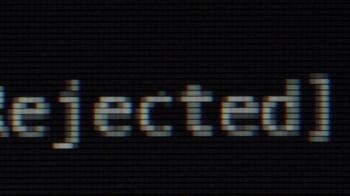
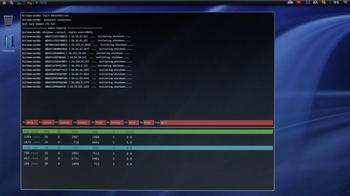
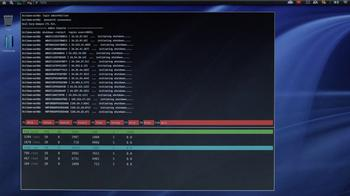
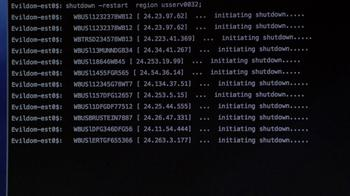
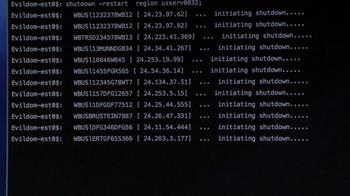
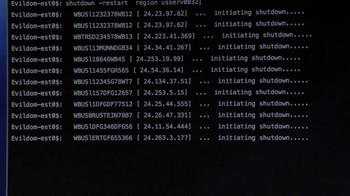
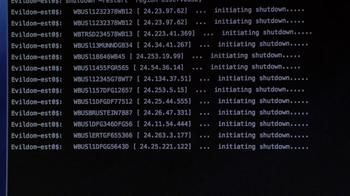
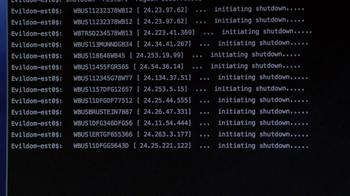
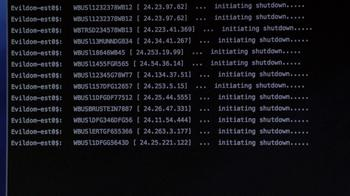
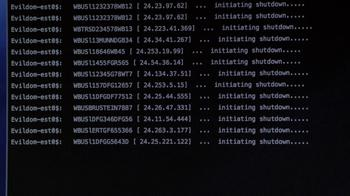
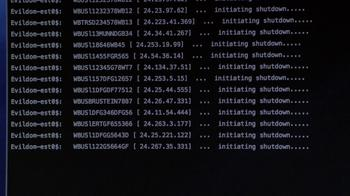
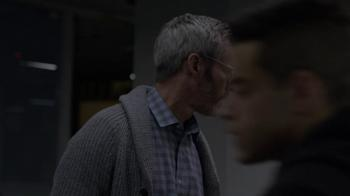
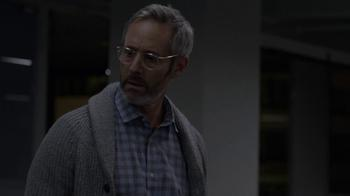
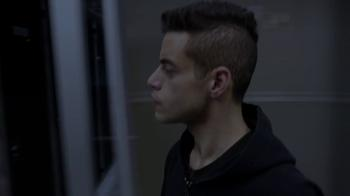
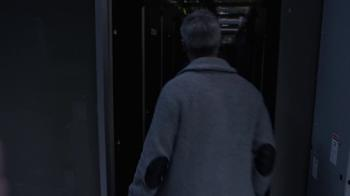
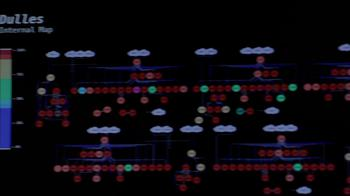
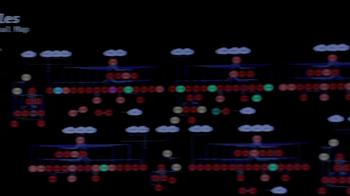
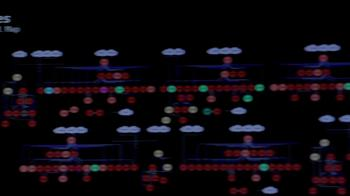
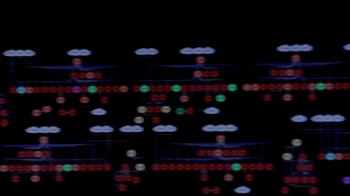
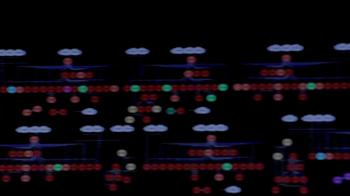
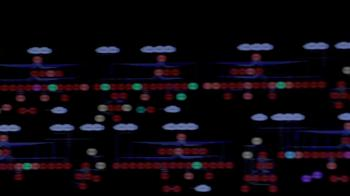
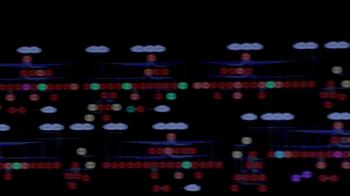
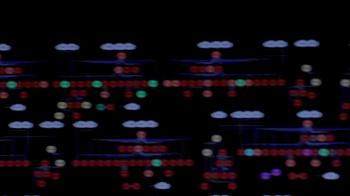
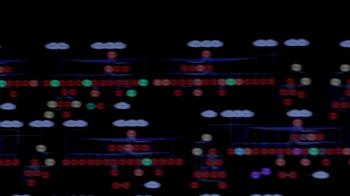
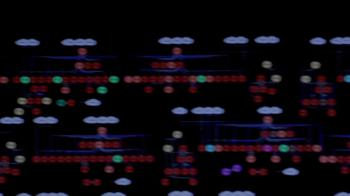
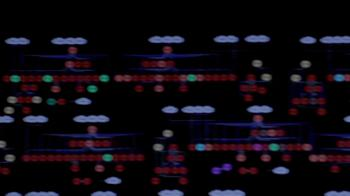
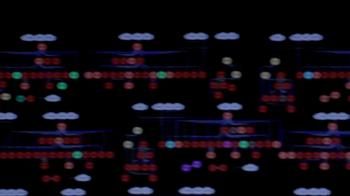
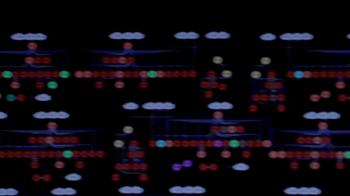
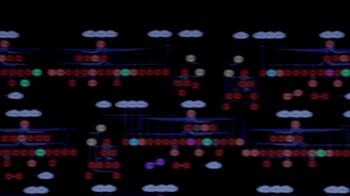
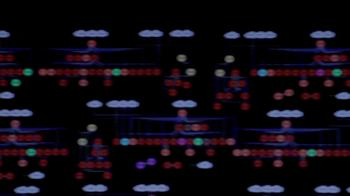
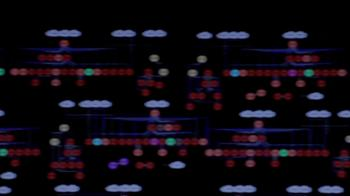
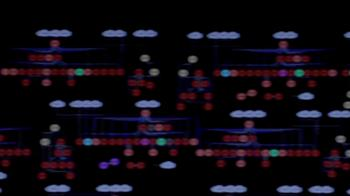
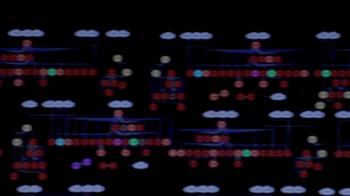
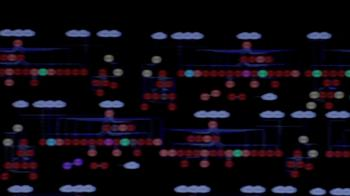
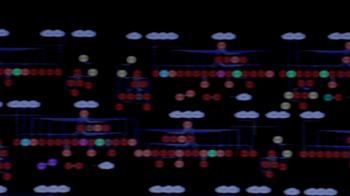
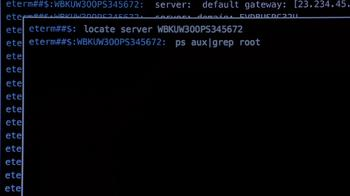
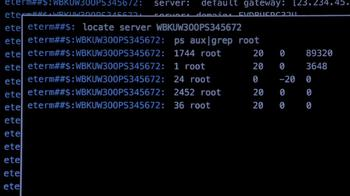
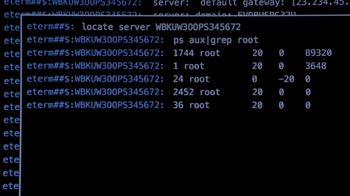
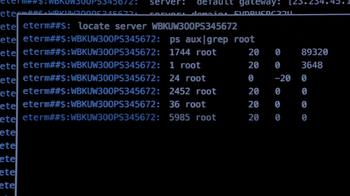
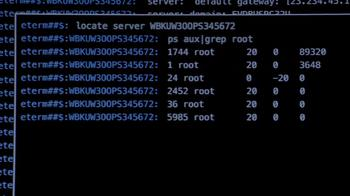
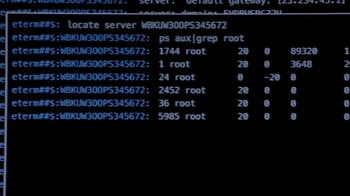
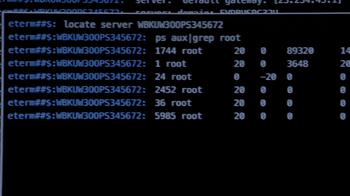
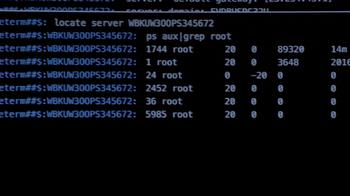
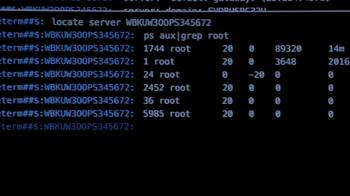
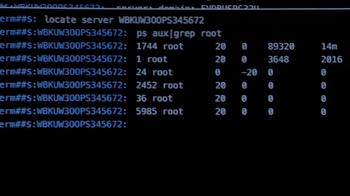
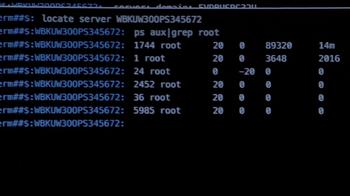
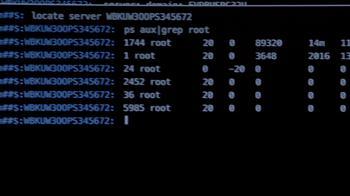
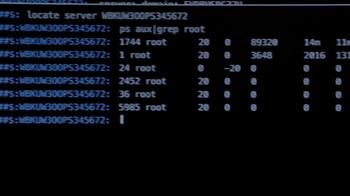
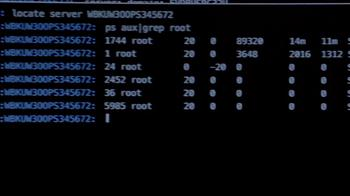
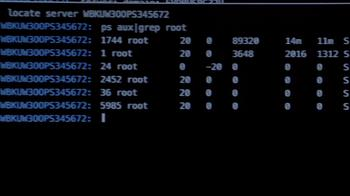
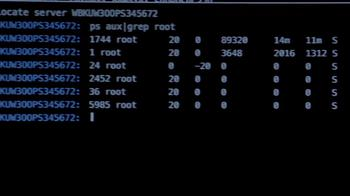
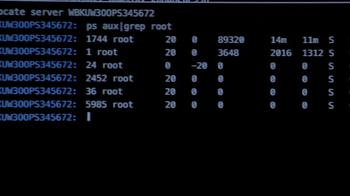
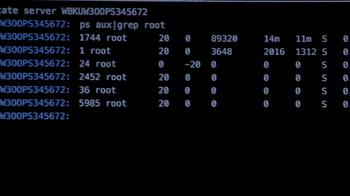
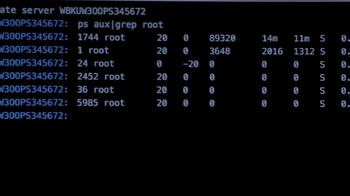
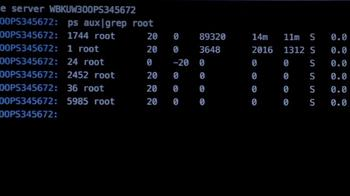
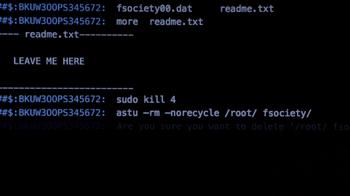
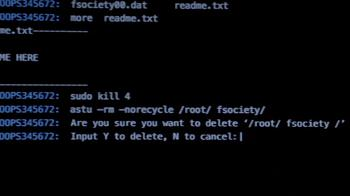
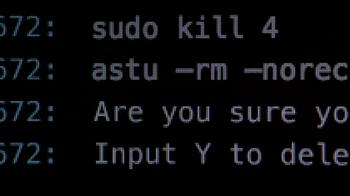
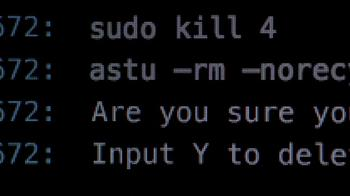
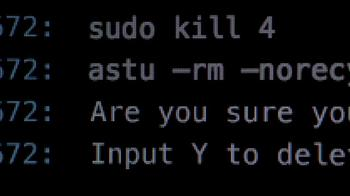
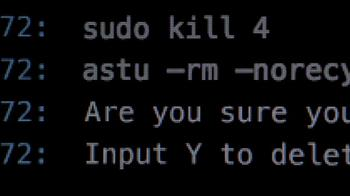
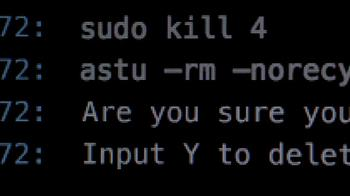
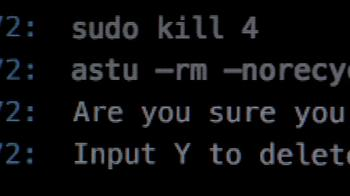
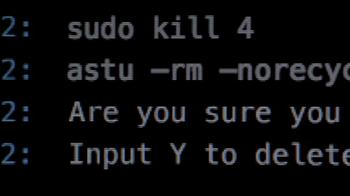
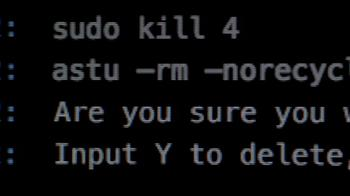
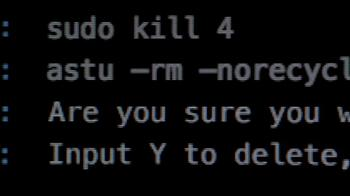
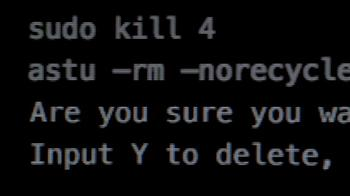
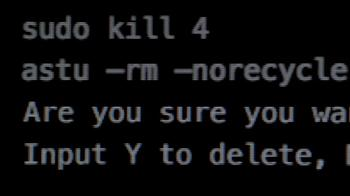
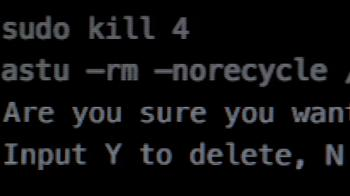
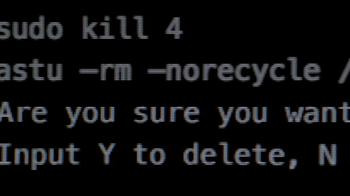
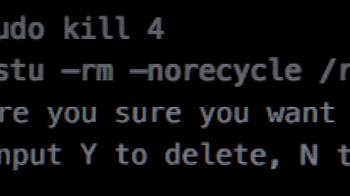
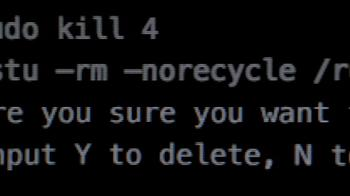
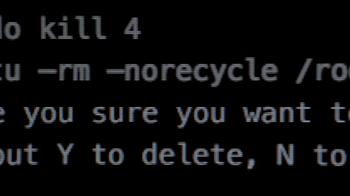
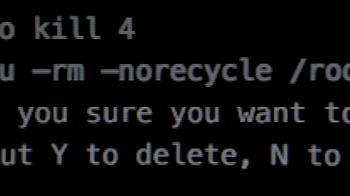
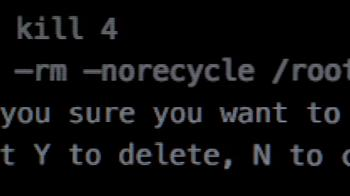
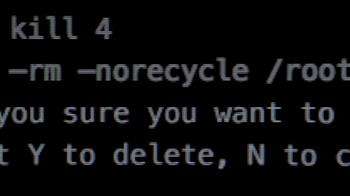
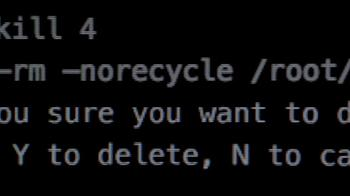
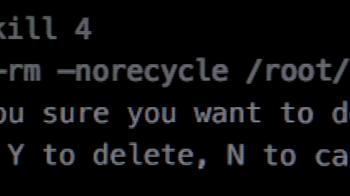
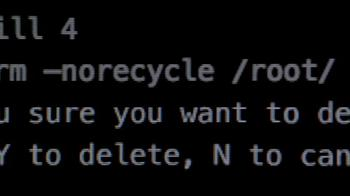
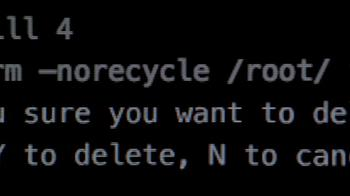
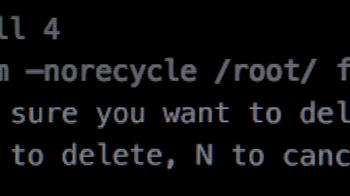
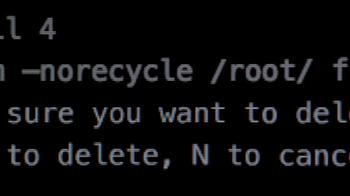
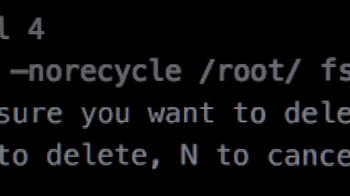
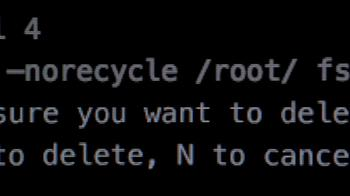
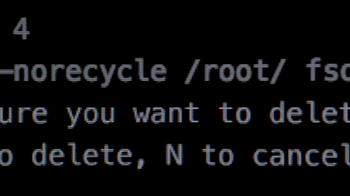
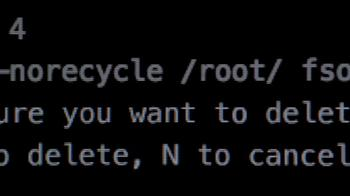
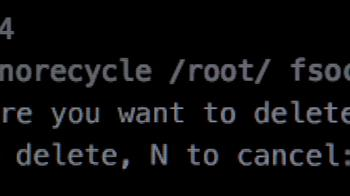
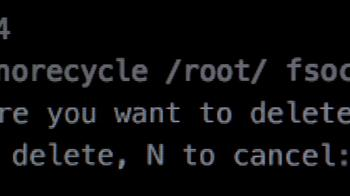
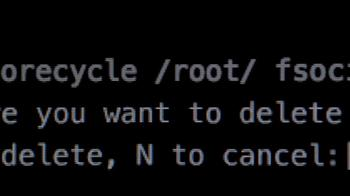
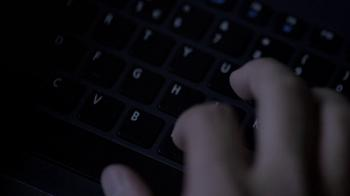
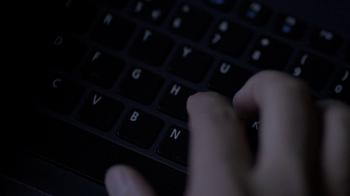
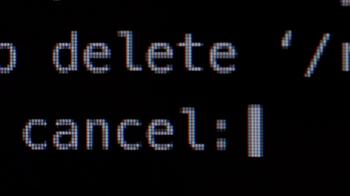
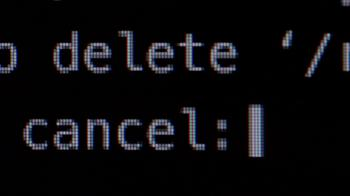
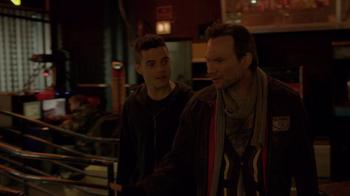
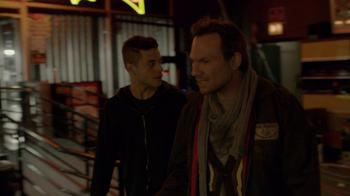
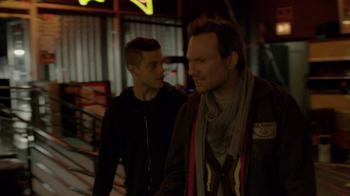
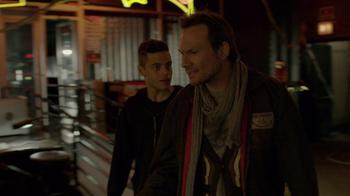
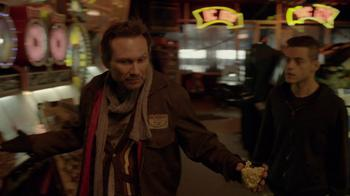
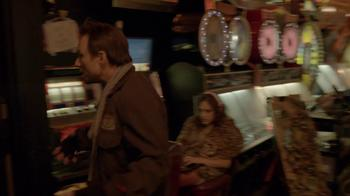
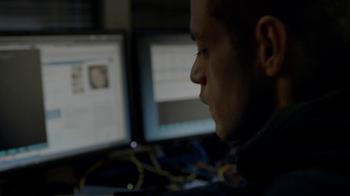
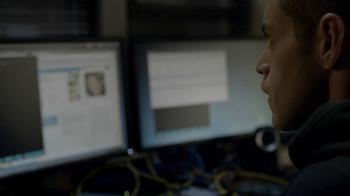
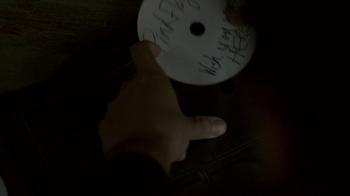
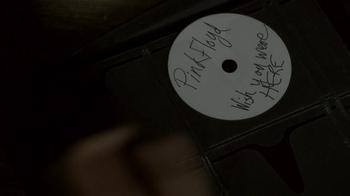

In [202]:
HTML(exp_2_short_scenes_complete[['scene_number', 'length', 'time_code', 'scene_start_image', 'scene_end_image']].to_html(
    formatters={'scene_start_image':image_formatter, 'scene_end_image':image_formatter}, escape=False))

# Third Attempt
I noticed that the detector is segmenting a number of scenes into multiple scenes despite being part of a single scene. In particular scenes that contain computer displays and a little bit of movement. There's a couple ways we can fix this issue.

For detecting scene changes, we're currently using the recommended Content-aware mode. From the docs:

> Content-aware mode looks at the difference between each pair of adjacent frames, triggering a scene break when this difference exceeds the threshold value. 

The camera moving while looking at computer monitors might trigger the detector because of the change in color values at each position. Generally speaking, Content-aware mode is better for the type of cuts that appear in a show/movie where it's instant and less-defined. There is another called Threshold-based Detection:

> Threshold-based mode is what most traditional scene detection programs use, which looks at the average intensity of the current frame, triggering a scene break when the intensity falls below the threshold (or crosses back upwards). 

This sets a threshold of absolute value of scene intensity. So if the value is low (i.e. if we're detecting a dark screen) we're established that the scene has ended. This wouldn't work that well for a show or movie where the cuts are less-defined.

I think a better choice for this next test is to continue using Content-aware mode, but increase the threshold setting so that the detector is less sensitive.

> **scenedetect -i mr-robot-half-size.m4v -d content -t 34 --csv-output OUTPUT.csv -si -m 4**

In [208]:
experiment_3_title = "experiment-3"
exp_3 = pd.read_csv("experiment-3.csv", skiprows=[0])
exp_3.columns = ['scene_number', 'frame_number_start', 'time_code', 'start_time', 'length']

Filter and move files

In [210]:
exp_3_short_scenes_dir = create_experiment_image_directory(experiment_3_title, "images/short-scenes")
exp_3_remaining_scenes_dir = create_experiment_image_directory(experiment_3_title, "images/remaining-scenes")

exp_3_short_scenes = exp_3[(exp_3.length < 0.5)]
exp_3_remaining_scenes = exp_3[(exp_3.length > 0.5)]

exp_3_short_scene_ids = exp_3_short_scenes['scene_number'].apply('{:0>3}'.format)
exp_3_remaining_scene_ids = exp_3_remaining_scenes['scene_number'].apply('{:0>3}'.format)

exp_3_short_scene_files = format_file_names(exp_3_short_scene_ids)
exp_3_remaining_scene_files = format_file_names(exp_3_remaining_scene_ids)

move_in_and_out_images(exp_3_short_scene_files, exp_3_short_scenes_dir)
move_in_and_out_images(exp_3_remaining_scene_files, exp_3_remaining_scenes_dir)

Then create a new DataFrame with Pillow information

In [211]:
exp_3_image_path = [(os.path.join(exp_3_short_scenes_dir, in_path), 
                            os.path.join(exp_3_short_scenes_dir, out_path))
                            for out_path, in_path in exp_3_short_scene_files]
exp_3_image_path = pd.DataFrame(exp_3_image_path)
exp_3_image_path.columns = ['scene_start', 'scene_end']
exp_3_short_scenes_complete = pd.concat([exp_3_short_scenes.reset_index(), exp_3_image_path], axis=1)

In [212]:
exp_3_short_scenes_complete['scene_start_image'] = exp_3_short_scenes_complete.scene_start.map(lambda f: get_thumbnail(f))
exp_3_short_scenes_complete['scene_end_image'] = exp_3_short_scenes_complete.scene_end.map(lambda f: get_thumbnail(f))


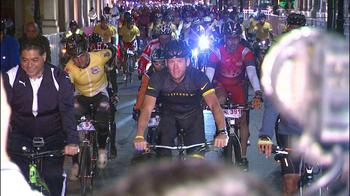
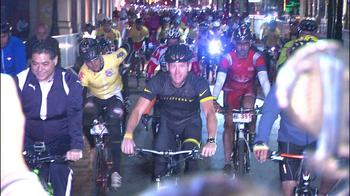
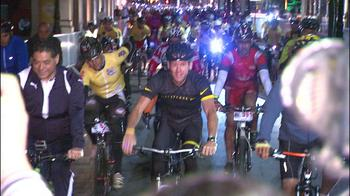
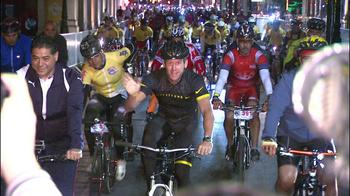
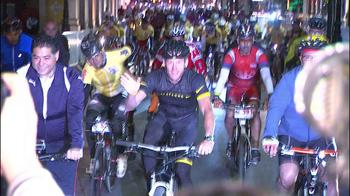
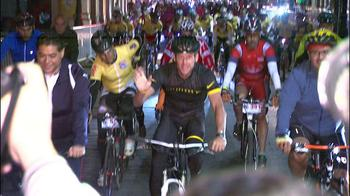
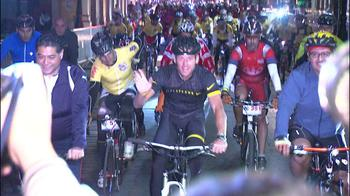
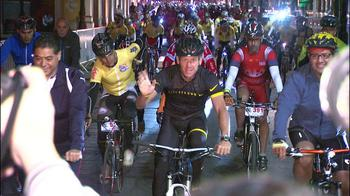
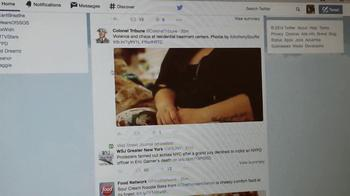
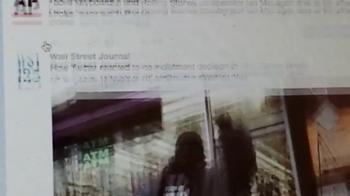
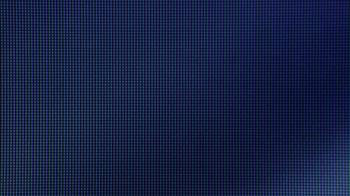
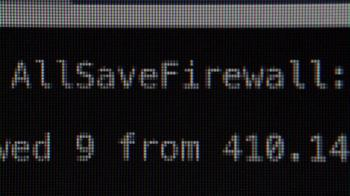
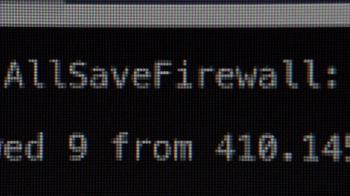
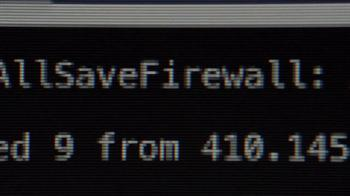
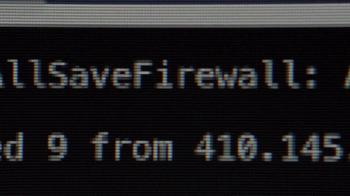
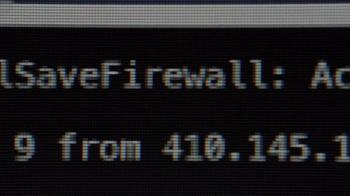
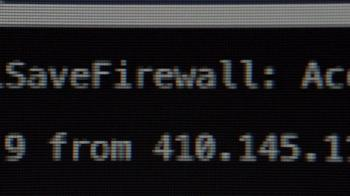
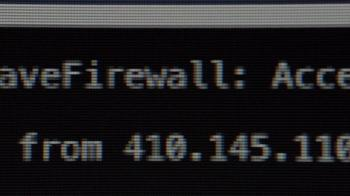
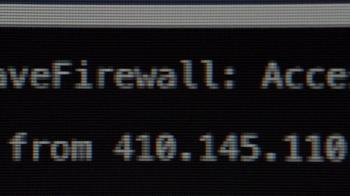
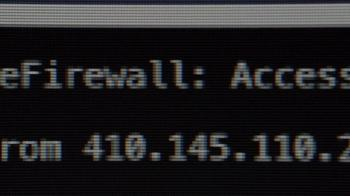
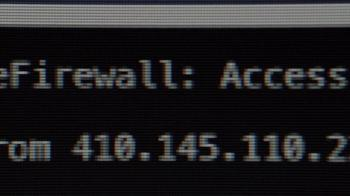
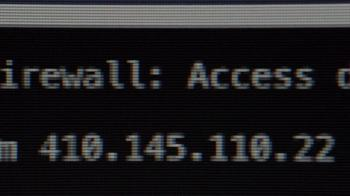
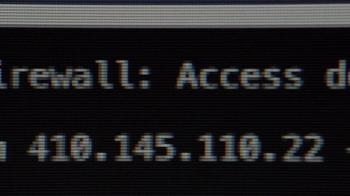
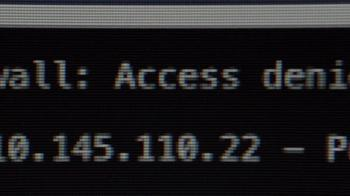
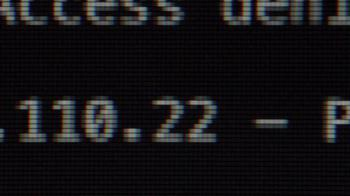
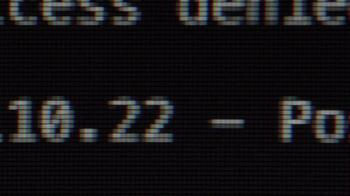
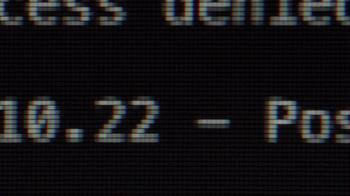
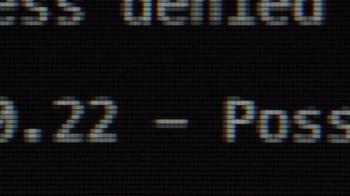
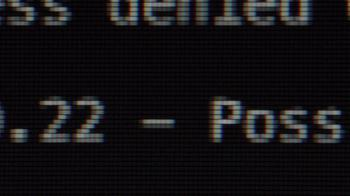
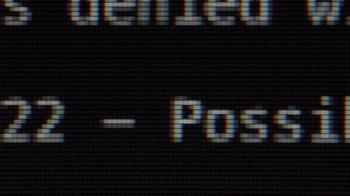
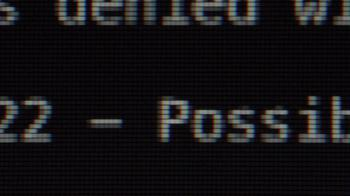
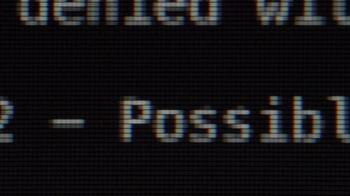
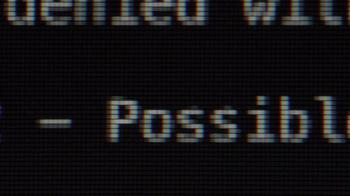
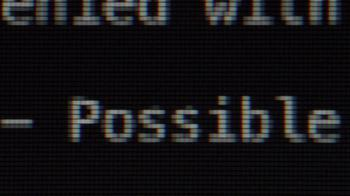
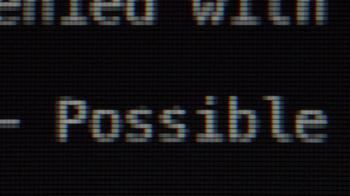
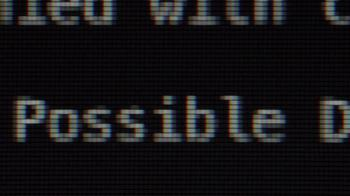
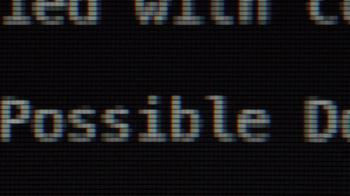
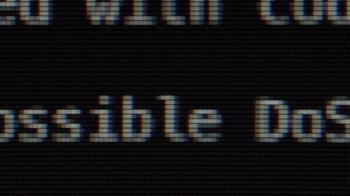
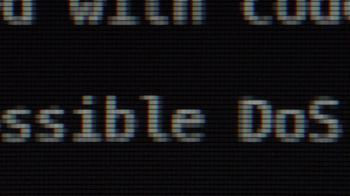
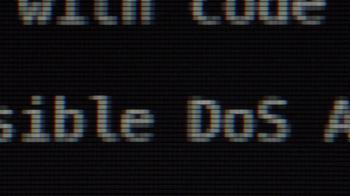
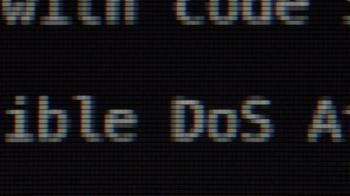
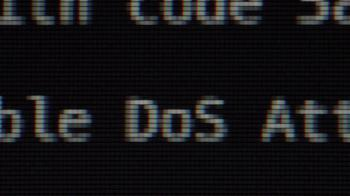
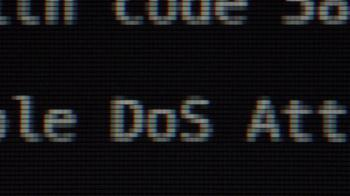
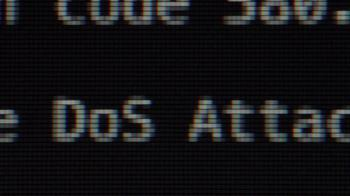
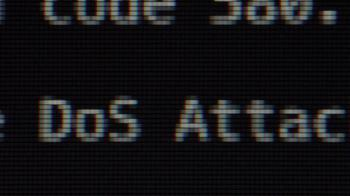
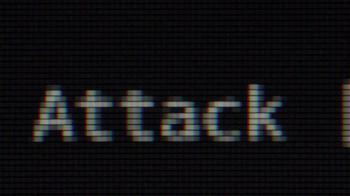
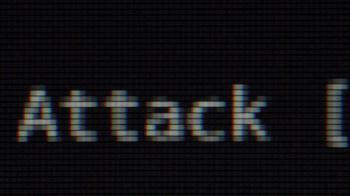
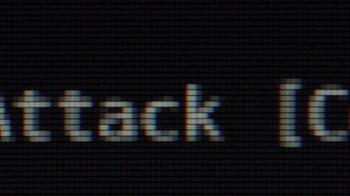
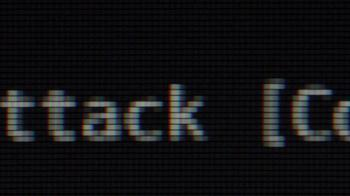
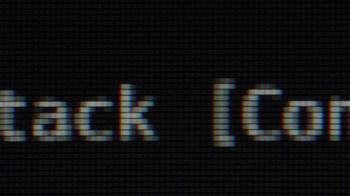
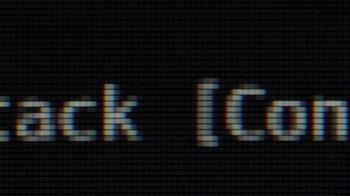
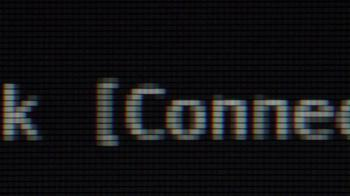
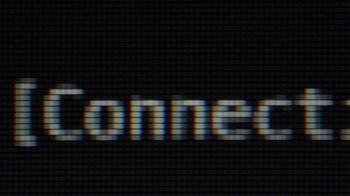
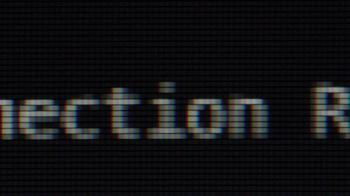
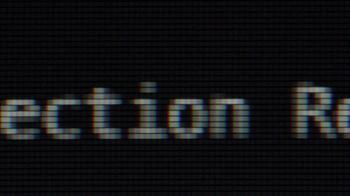
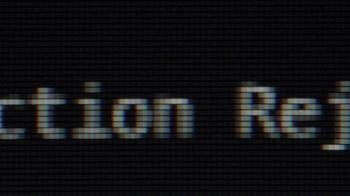
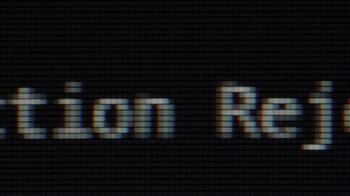
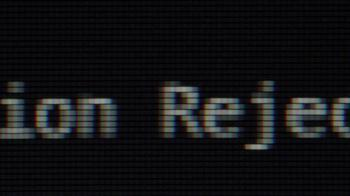
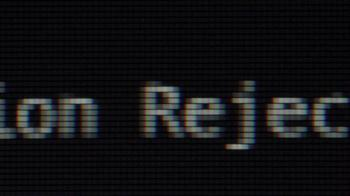
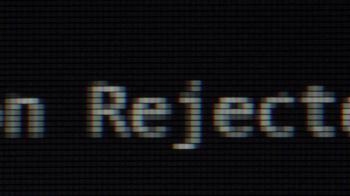
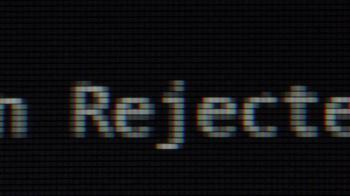
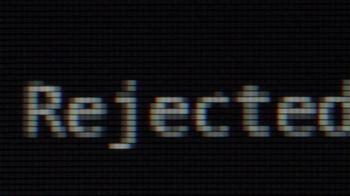
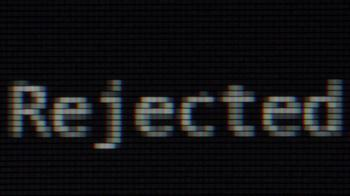
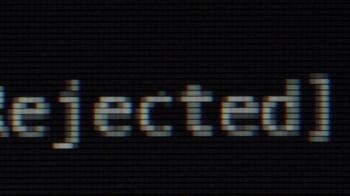
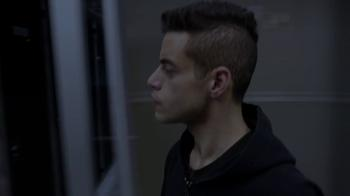
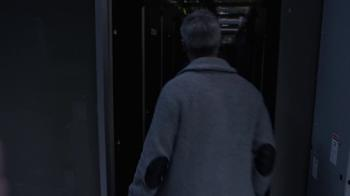
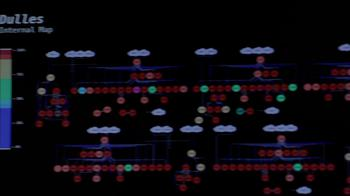
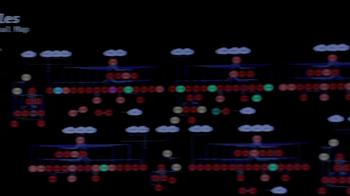
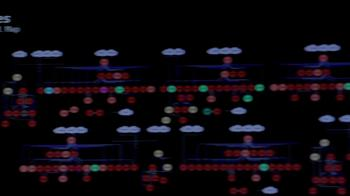
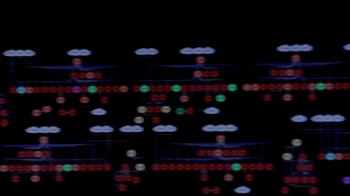
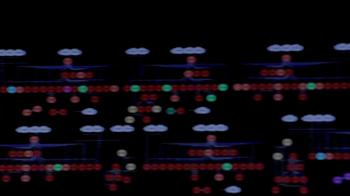
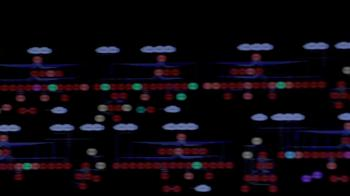
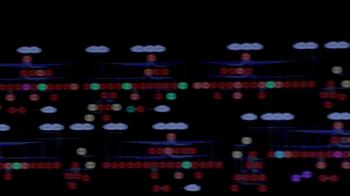
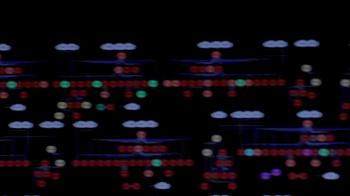
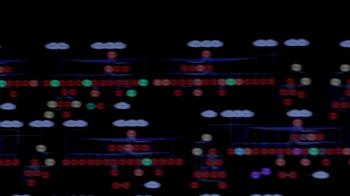
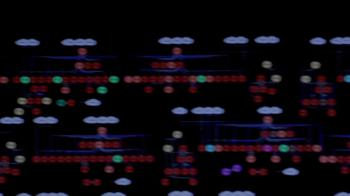
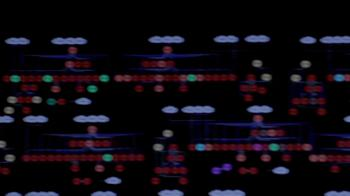
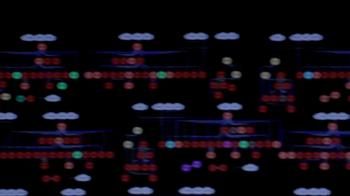
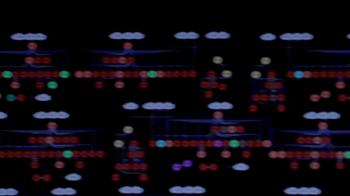
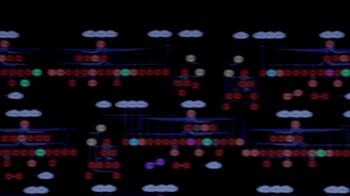
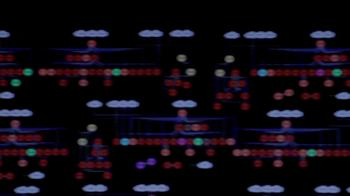
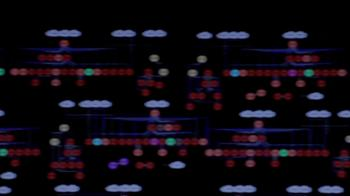
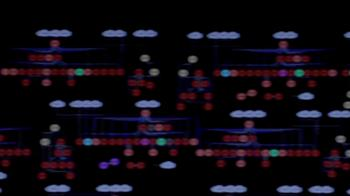
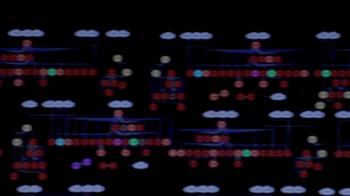
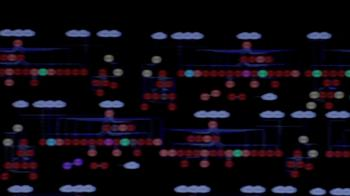
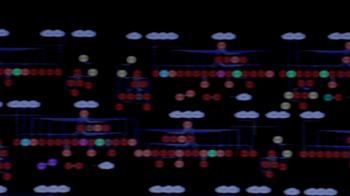
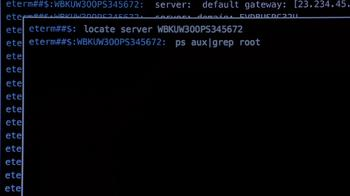
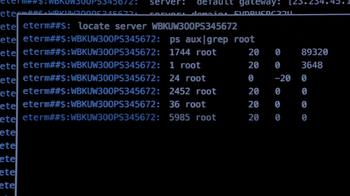
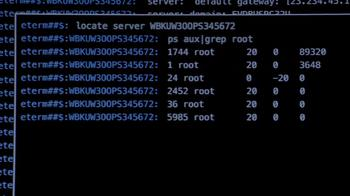
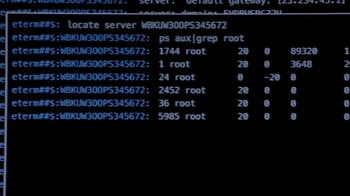
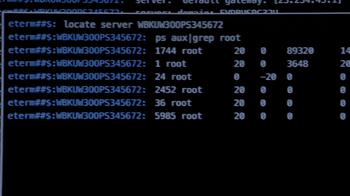
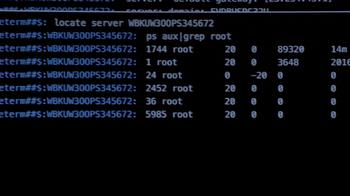
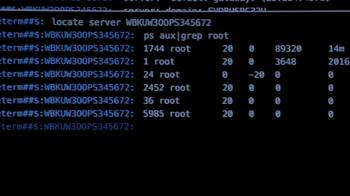
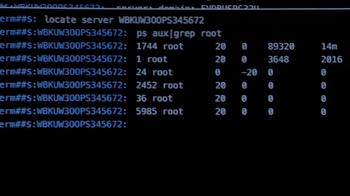
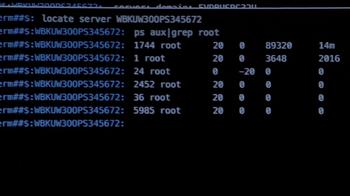
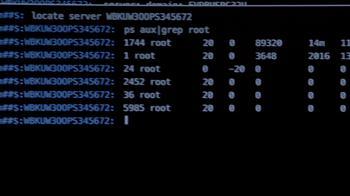
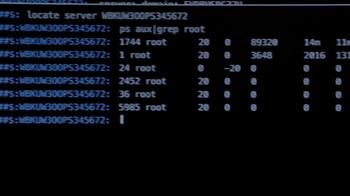
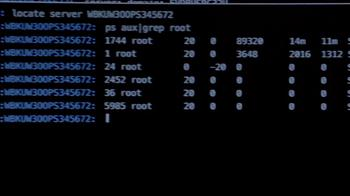
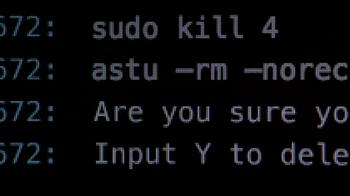
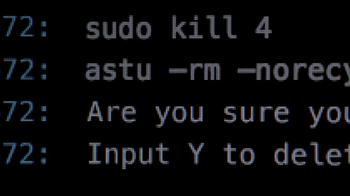
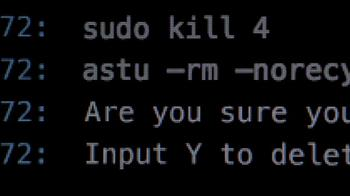
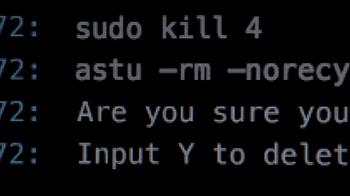
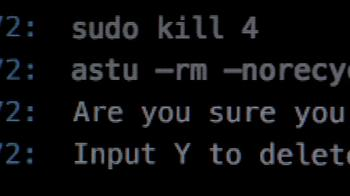
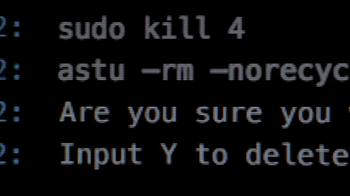
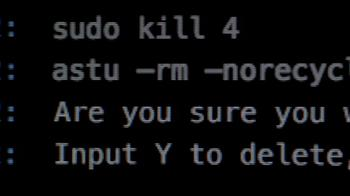
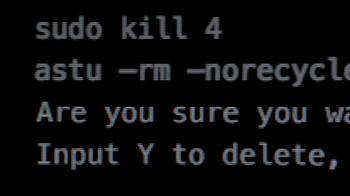
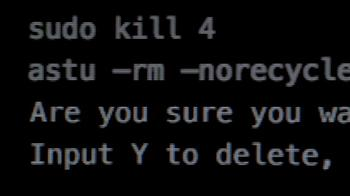
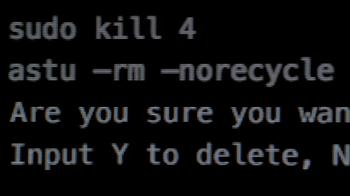
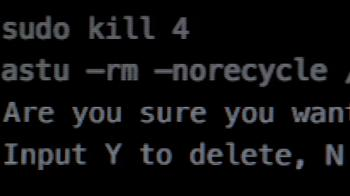
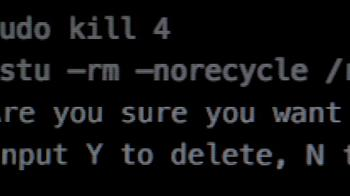
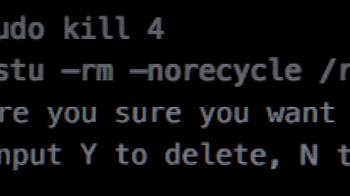
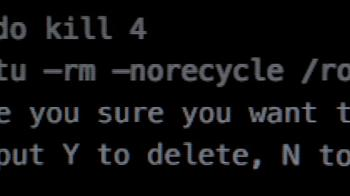
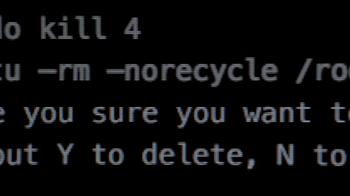
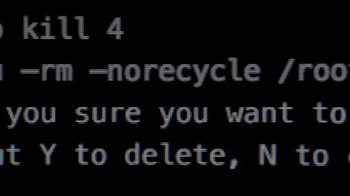
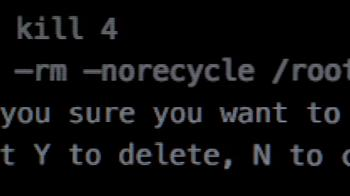
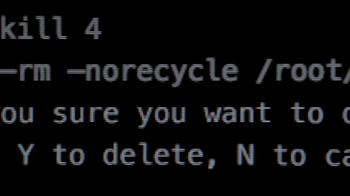
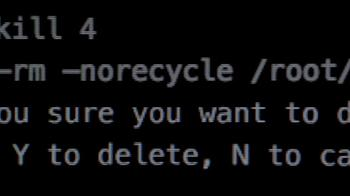
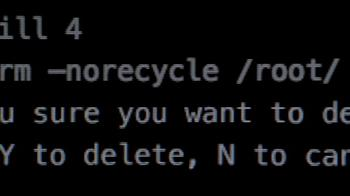
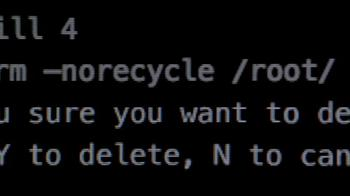
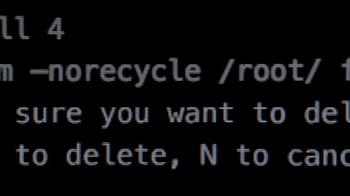
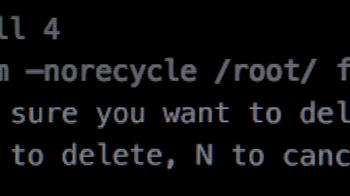
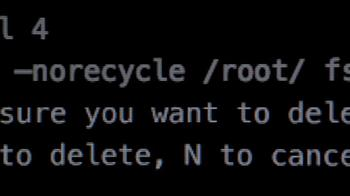
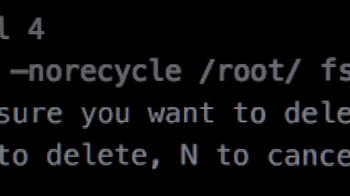
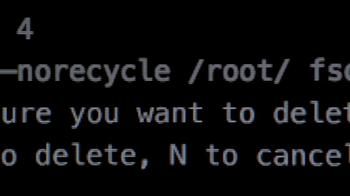
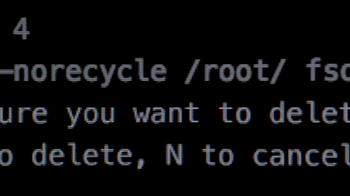
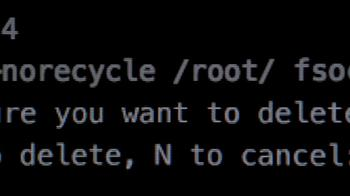
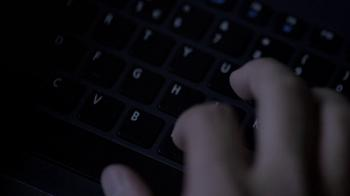
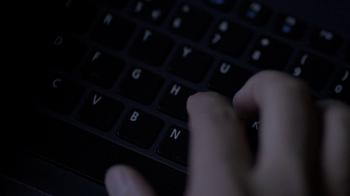
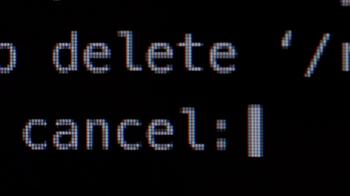
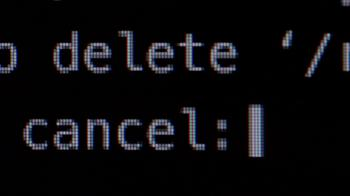
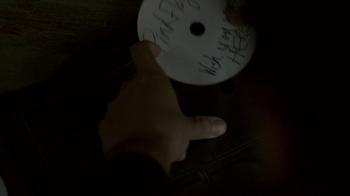
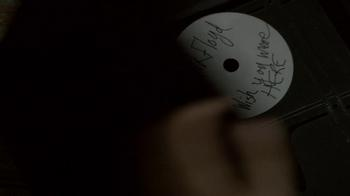

In [213]:
HTML(exp_3_short_scenes_complete[['scene_number', 'length', 'time_code', 'scene_start_image', 'scene_end_image']].to_html(
    formatters={'scene_start_image':image_formatter, 'scene_end_image':image_formatter}, escape=False))

## Fourth Attempt

By increasing the threshold, the third attempt managed to eliminate some of the non-screen transitions. We're still getting quite a bit of noisy results as the computer screens constantly show up despite not moving much.

Just out of curiousity I want to see what happens if I basically allow for only 1 frame to be the minimum.

> **scenedetect -i mr-robot-half-size.m4v -d content -t 34 --csv-output OUTPUT.csv -si -m 1**

In [218]:
class Experiment:
    
    def __init__(self, experiment_name, csv_file=None, threshold=0.5):
        self.experiment_name = experiment_name
        if csv_file is not None:
            self.add_csv(csv_file)
        self.threshold = threshold
        
    def __str__(self):
        return 
      
    def create_image_directory(self, folder_path):
        directory = os.path.join(self.experiment_name, folder_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        return directory

    def add_csv(self, csv):
        input_data = pd.read_csv(csv, skiprows=[0])        
        input_data.columns = ['scene_number', 'frame_number_start', 'time_code', 'start_time', 'length']
        self.short_scenes = input_data[(input_data.length < self.threshold)]
        self.remaining_scenes = input_data[(input_data.length > self.threshold)]
    
    def organize_and_move_experiment_images(self):
        
        # Returns a list of tuples of filenames
        short_scenes_filenames = self.parse_scene_filenames(self.short_scenes)
        remaining_scenes_filenames = self.parse_scene_filenames(self.remaining_scenes)

        short_scenes_dir = self.create_image_directory("images/short-scenes")
        remaining_scenes_dir = self.create_image_directory("images/remaining-scenes")
        
        move_in_and_out_images(short_scenes_filenames, short_scenes_dir)
        move_in_and_out_images(remaining_scenes_filenames, remaining_scenes_dir)
        
        self.concat_image_paths_to_short_scenes(short_scenes_filenames, short_scenes_dir)
                
    def concat_image_paths_to_short_scenes(self, files, directory):
        image_path = [(os.path.join(directory, in_path),
                       os.path.join(directory, out_path)) for out_path, in_path in files]
        df =  pd.DataFrame(image_path)
        df.columns = ['scene_start', 'scene_end']
        self.short_scenes_with_image_path = pd.concat([self.short_scenes.reset_index(), df], axis=1)
        
    def parse_scene_filenames(self, input_data):
        input_data_ids = input_data['scene_number'].apply('{:0>3}'.format)
        return format_file_names(input_data_ids)

    def get_short_scenes_dir(self):
        return self.short_scenes_dir
    
    def get_remaining_scenes_dir(self):
        return self.remaining_scenes_dir
    
    def get_scenes(self):
        return self.short_scenes_with_image_path


In [220]:
experiment_4 = Experiment("experiment-4")
experiment_4.add_csv("experiment-4.csv")
experiment_4.organize_and_move_experiment_images()

In [225]:
len(experiment_4_table)

250


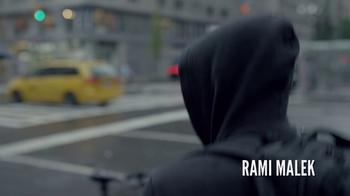
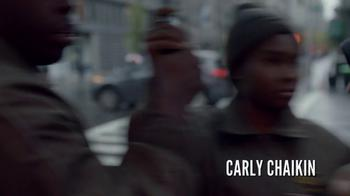
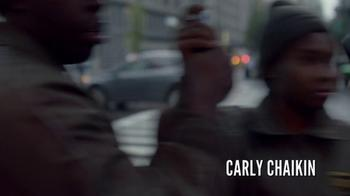
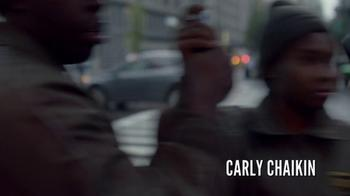
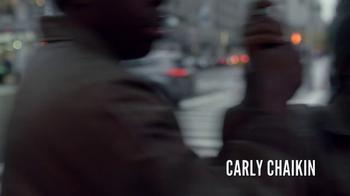
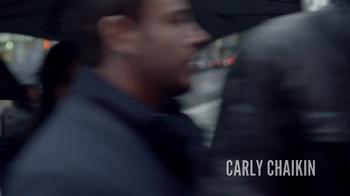
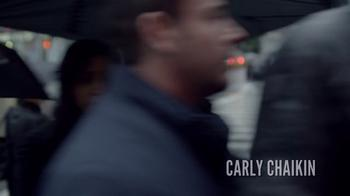
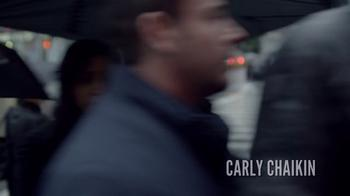
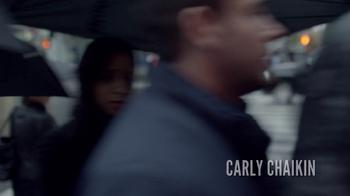
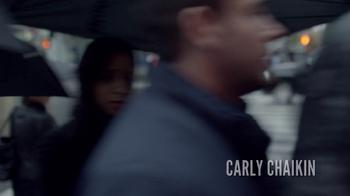
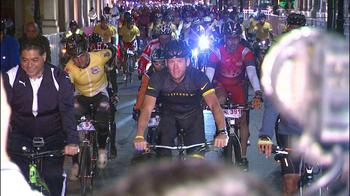
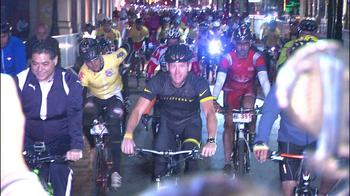
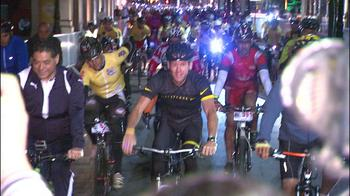
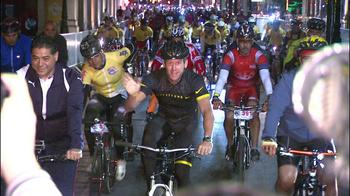
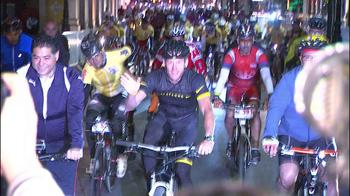
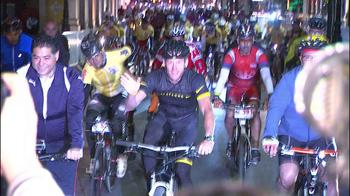
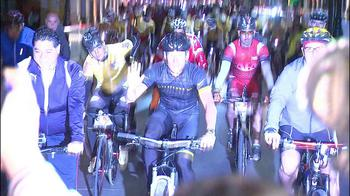
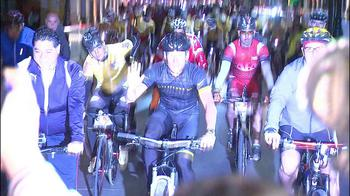
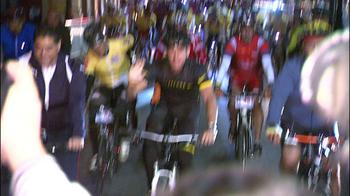
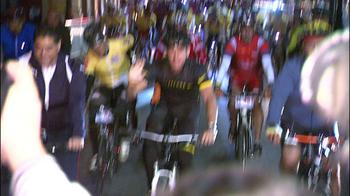
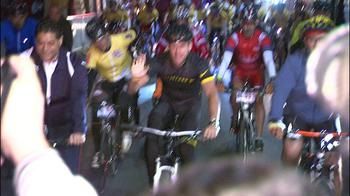
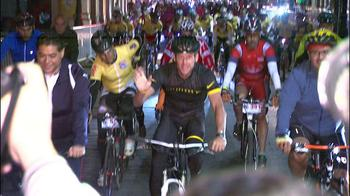
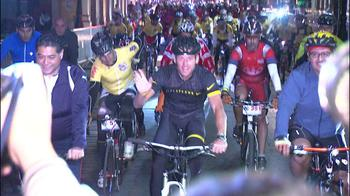
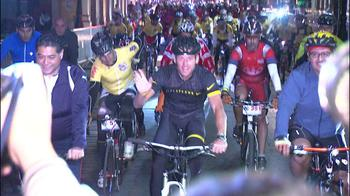
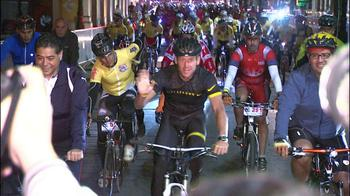
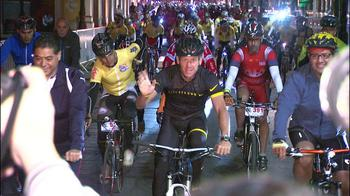
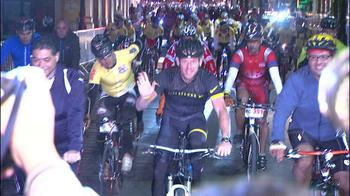
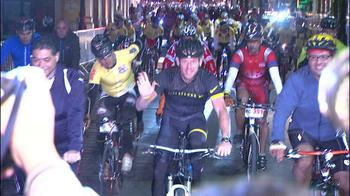
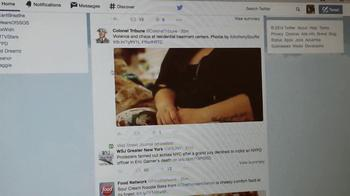
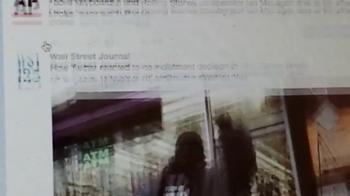
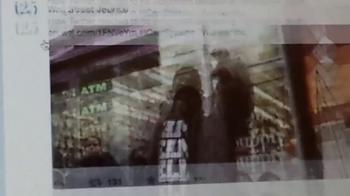
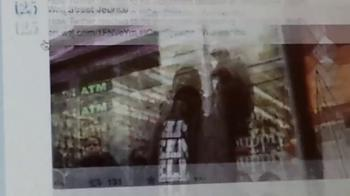
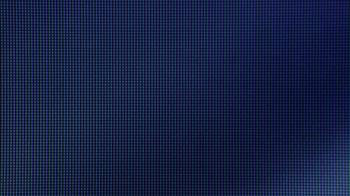
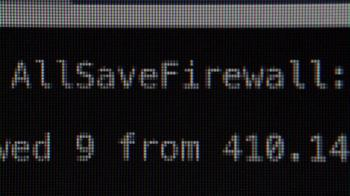
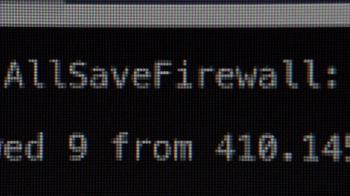
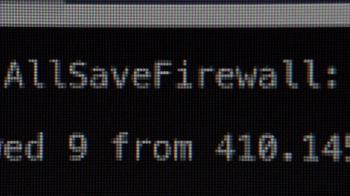
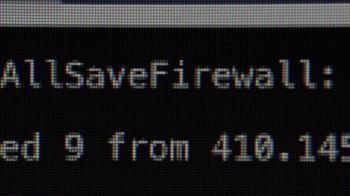
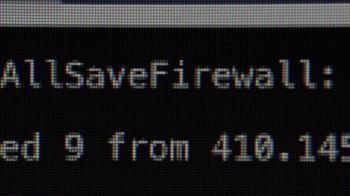
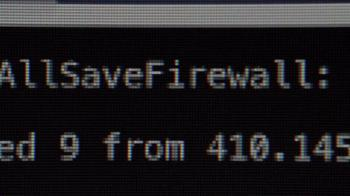
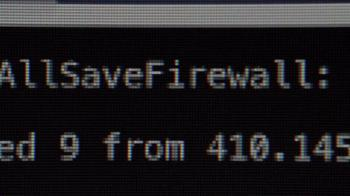
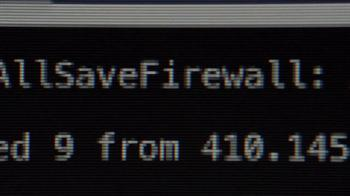
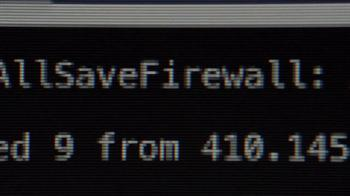
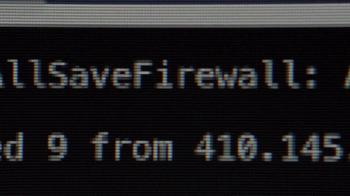
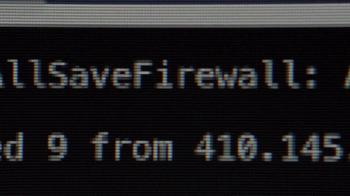
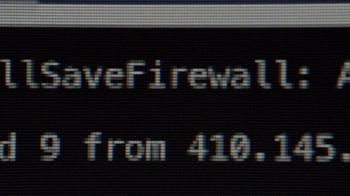
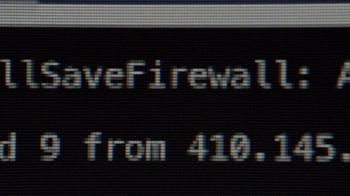
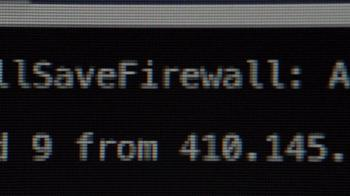
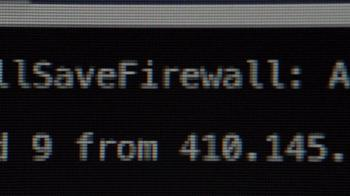
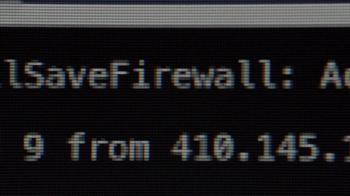
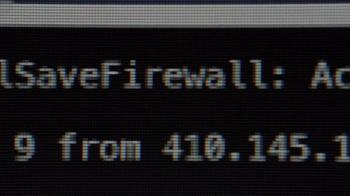
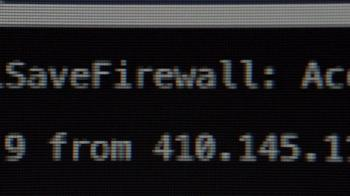
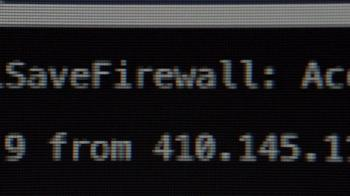
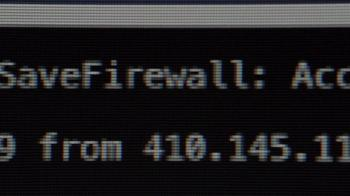
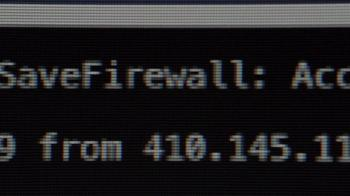
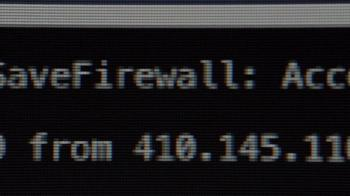
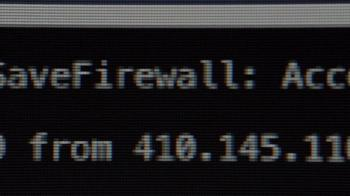
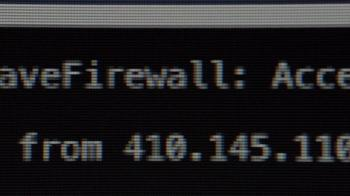
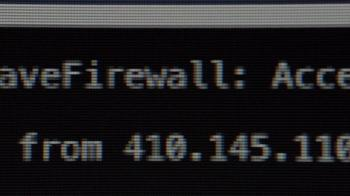
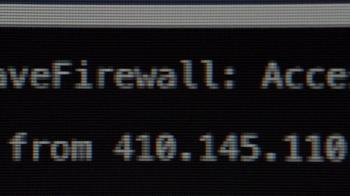
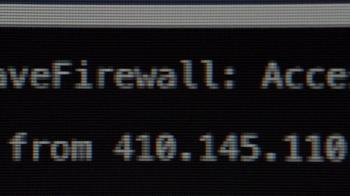
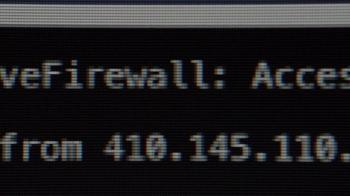
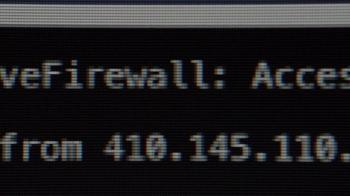
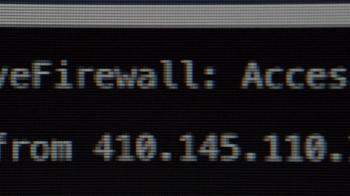
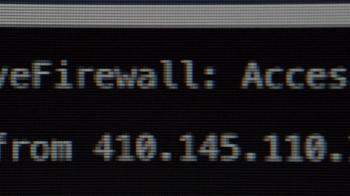
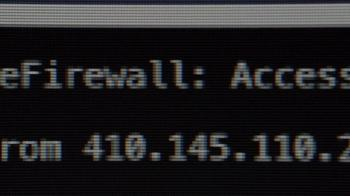
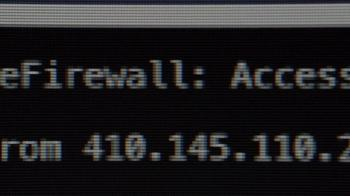
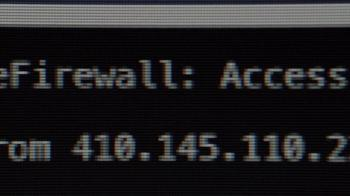
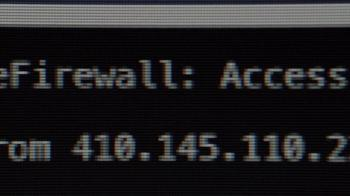
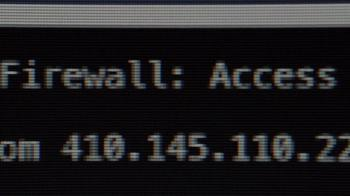
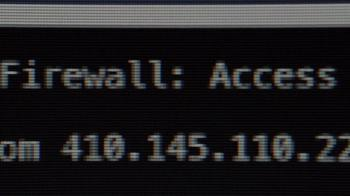
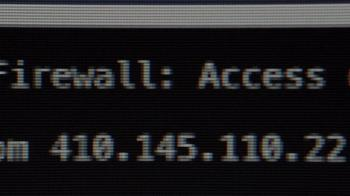
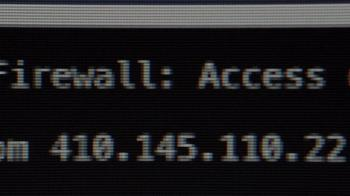
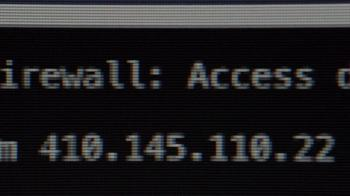
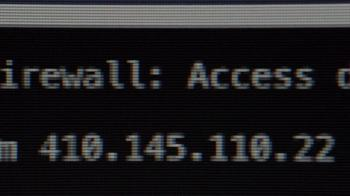
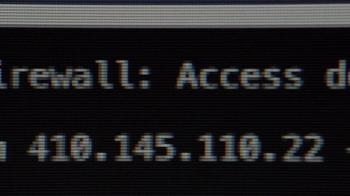
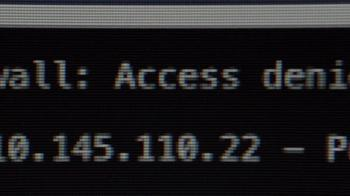
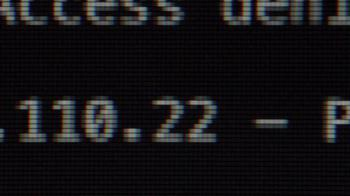
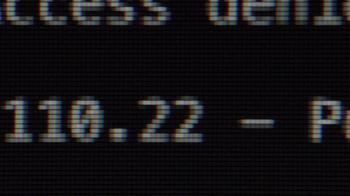
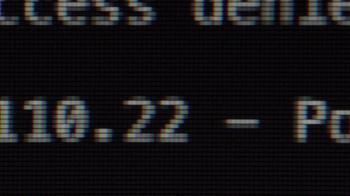
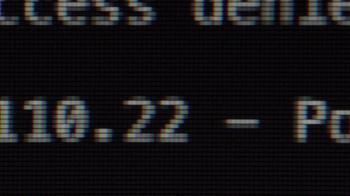
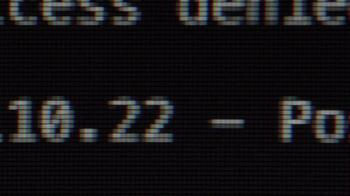
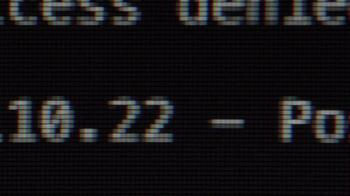
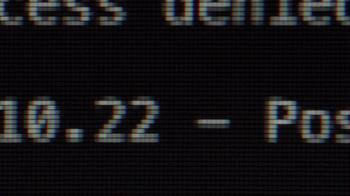
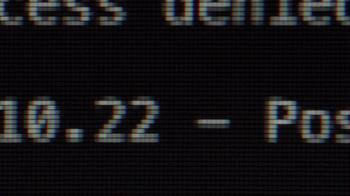
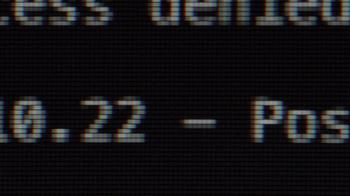
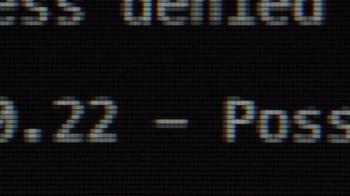
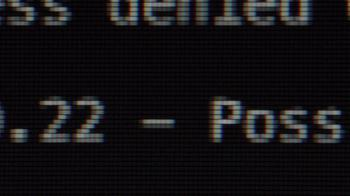
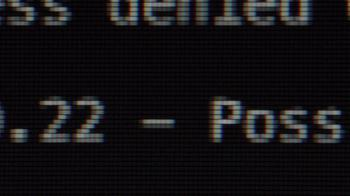
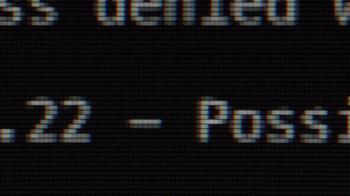
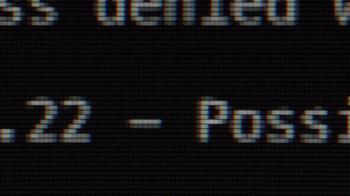
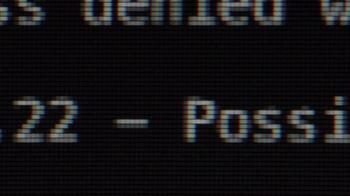
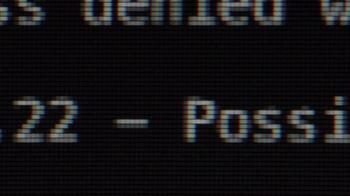
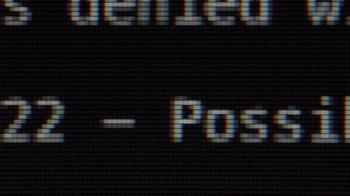
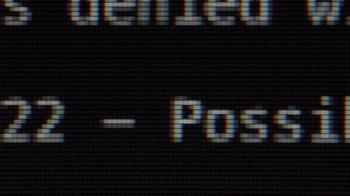
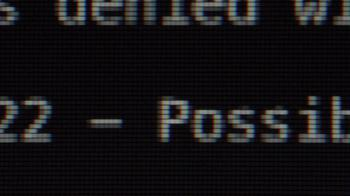
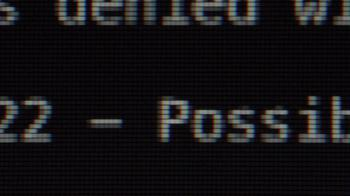
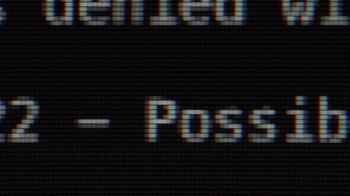
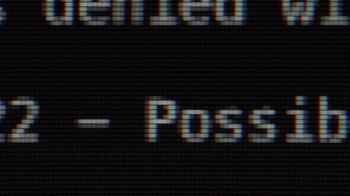
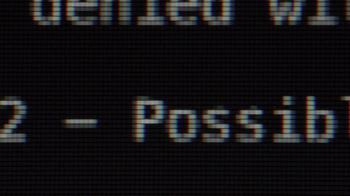
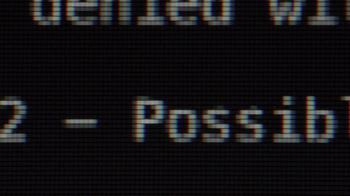

In [232]:
experiment_4_table = experiment_4.get_scenes()
experiment_4_table['scene_start_image'] = experiment_4_table.scene_start.map(lambda f: get_thumbnail(f))
experiment_4_table['scene_end_image'] = experiment_4_table.scene_end.map(lambda f: get_thumbnail(f))
HTML(experiment_4_table[['scene_number', 'length', 'time_code', 'scene_start_image', 'scene_end_image']].head(50).to_html(
    formatters={'scene_start_image':image_formatter, 'scene_end_image':image_formatter}, escape=False))

As expected, by removing the minimum frames per second per scene, the scene detector ends up creating many more scenes than what we would normally classify as a scene. I'm just showing the first 50 results but the number of 'scenes' that the scene detector created that is less than half a second is **250**.